In [1]:
import json
import multiprocessing
import cv2
import albumentations as A
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import pandas as pd
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime
import math
import random

from timm.utils.model_ema import ModelEmaV2

# Config

In [2]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2


class CFG:
    # ============== comp exp name =============
    comp_name = 'atmacup_18'  # comp名

    comp_dataset_path = '../raw/atmacup_18_dataset/'

    exp_name = 'atmacup_18_cnn_conv_tiny'

    is_debug = False
    use_gray_scale = False

    model_in_chans = 9  # モデルの入力チャンネル数

    # ============== file path =============
    train_fold_dir = "../proc/baseline/folds/"

    # ============== model cfg =============
    model_name = "convnextv2_tiny"

    num_frames = 3  # model_in_chansの倍数
    norm_in_chans = 1 if use_gray_scale else 3

    use_torch_compile = False
    use_ema = True
    ema_decay = 0.995
    # ============== training cfg =============
    size = 224  # 224

    batch_size = 64  # 32

    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 40
    if is_debug:
        epochs = 2

    # adamW warmupあり
    warmup_factor = 10
    lr = 1e-4
    if scheduler == 'GradualWarmupSchedulerV2':
        lr /= warmup_factor

    # ============== fold =============
    n_fold = 5
    use_holdout = False
    use_alldata = False
    train_folds = [0, 1, 2, 3, 4]

    skf_col = 'class'
    group_col = 'scene'
    fold_type = 'gkf'

    objective_cv = 'regression'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'minimize'  # 'maximize', 'minimize'
    metrics = 'calc_mae_atmacup'

    # ============== pred target =============
    target_size = 18
    target_col = ['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'x_2', 'y_2',
                  'z_2', 'x_3', 'y_3', 'z_3', 'x_4', 'y_4', 'z_4', 'x_5', 'y_5', 'z_5']


    # ============== ほぼ固定 =============
    pretrained = True
    inf_weight = 'last'  # 'best'

    min_lr = 5e-8
    weight_decay = 1e-5
    max_grad_norm = 1000

    print_freq = 500
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    if exp_name is not None:
        print('set dataset path')

        outputs_path = f'../proc/baseline/outputs/{exp_name}/'

        submission_dir = outputs_path + 'submissions/'
        submission_path = submission_dir + f'submission_{exp_name}.csv'

        model_dir = outputs_path + \
            f'{comp_name}-models/'

        figures_dir = outputs_path + 'figures/'

        log_dir = outputs_path + 'logs/'
        log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.Downscale(p=0.25),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
        # A.RandomRotate90(p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        # A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        # A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        # A.CoarseDropout(max_holes=1, max_height=int(
        #     size * 0.3), max_width=int(size * 0.3), p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),

        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2(),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2(),
    ]

set dataset path


In [3]:
print("CUDA が利用可能か:", torch.cuda.is_available())
print("利用可能な CUDA デバイス数:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("現在の CUDA デバイス:", torch.cuda.get_device_name(0))

CUDA が利用可能か: True
利用可能な CUDA デバイス数: 1
現在の CUDA デバイス: NVIDIA GeForce RTX 3090


# make fold

In [4]:
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


def get_fold(train, cfg):
    if cfg.fold_type == 'kf':
        Fold = KFold(n_splits=cfg.n_fold,
                     shuffle=True, random_state=cfg.seed)
        kf = Fold.split(train, train[cfg.target_col])
    elif cfg.fold_type == 'skf':
        Fold = StratifiedKFold(n_splits=cfg.n_fold,
                               shuffle=True, random_state=cfg.seed)
        kf = Fold.split(train, train[cfg.skf_col])
    elif cfg.fold_type == 'gkf':
        Fold = GroupKFold(n_splits=cfg.n_fold)
        groups = train[cfg.group_col].values
        kf = Fold.split(train, train[cfg.group_col], groups)
    elif cfg.fold_type == 'sgkf':
        Fold = StratifiedGroupKFold(n_splits=cfg.n_fold,
                                    shuffle=True, random_state=cfg.seed)
        groups = train[cfg.group_col].values
        kf = Fold.split(train, train[cfg.skf_col], groups)
    # elif fold_type == 'mskf':
    #     Fold = MultilabelStratifiedKFold(
    #         n_splits=cfg.n_fold, shuffle=True, random_state=cfg.seed)
    #     kf = Fold.split(train, train[cfg.skf_col])

    for n, (train_index, val_index) in enumerate(kf):
        train.loc[val_index, 'fold'] = int(n)
    train['fold'] = train['fold'].astype(int)

    print(train.groupby('fold').size())

    return train

In [5]:
def make_train_folds():
    train_df = pd.read_csv(CFG.comp_dataset_path + 'train_features.csv')

    train_df['scene'] = train_df['ID'].str.split('_').str[0]

    print('group', CFG.group_col)
    print(f'train len: {len(train_df)}')

    train_df = get_fold(train_df, CFG)

    # print(train_df.groupby(['fold', CFG.target_col]).size())
    print(train_df['fold'].value_counts())

    os.makedirs(CFG.train_fold_dir, exist_ok=True)

    train_df.to_csv(CFG.train_fold_dir +
                    'train_folds.csv', index=False)

In [6]:
make_train_folds()

group scene
train len: 43371
fold
0    8675
1    8674
2    8674
3    8674
4    8674
dtype: int64
fold
0    8675
1    8674
2    8674
3    8674
4    8674
Name: count, dtype: int64


# setting

In [7]:
# 乱数固定
def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)

    if mode == 'train':
        make_dirs(cfg)

In [8]:
cfg_init(CFG)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# logger

In [10]:
# from common_utils.logger import init_logger, wandb_init, AverageMeter, timeSince
# from common_utils.settings import cfg_init

def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [11]:
Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------
2024年11月23日 07:41:12


# eval function

In [12]:
def get_score(y_true, y_pred):
    # return roc_auc_score(y_true, y_pred)
    eval_func = eval(CFG.metrics)
    return eval_func(y_true, y_pred)


def calc_mae_atmacup(y_true, y_pred):
    abs_diff = np.abs(y_true - y_pred)  # 各予測の差分の絶対値を計算して
    mae = np.mean(abs_diff.reshape(-1, ))  # 予測の差分の絶対値の平均を計算

    return mae

def get_result(result_df):

    # preds = result_df['preds'].values

    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]
    preds = result_df[pred_cols].values
    labels = result_df[CFG.target_col].values
    score = get_score(labels, preds)
    Logger.info(f'score: {score:<.4f}')

    return score

# image utils

In [13]:
def draw_traffic_light(image, id):
    path = f'./datasets/atmacup_18/traffic_lights/{id}.json'
    traffic_lights = json.load(open(path))

    traffic_class = ['green',
                     'straight', 'left', 'right', 'empty', 'other', 'yellow', 'red']
    class_to_idx = {
        cls: idx for idx, cls in enumerate(traffic_class)
    }

    for traffic_light in traffic_lights:
        bbox = traffic_light['bbox']
        x1, y1, x2, y2 = bbox
        # int
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        point1 = (x1, y1)
        point2 = (x2, y2)

        idx = class_to_idx[traffic_light['class']]
        color = 255 - int(255*(idx/len(traffic_class)))

        cv2.rectangle(image, point1, point2, color=color, thickness=1)

    return image


def read_image_for_cache(path):
    if CFG.use_gray_scale:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # image = cv2.resize(image, (CFG.size, CFG.size))

    # 効かない
    # image = draw_traffic_light(image, path.split('/')[-2])
    return (path, image)


def make_video_cache(paths):
    debug = []
    for idx in range(9):
        color = 255 - int(255*(idx/9))
        debug.append(color)
    print(debug)

    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        res = pool.imap_unordered(read_image_for_cache, paths)
        res = tqdm(res)
        res = list(res)

    return dict(res)

# dataset

In [14]:
from albumentations import ReplayCompose
from torch.utils.data import DataLoader, Dataset
import albumentations as A

def get_transforms(data, cfg):
    if data == 'train':
        # aug = A.Compose(cfg.train_aug_list)
        aug = A.ReplayCompose(cfg.train_aug_list)
    elif data == 'valid':
        # aug = A.Compose(cfg.valid_aug_list)
        aug = A.ReplayCompose(cfg.valid_aug_list)

    # print(aug)
    return aug


class CustomDataset(Dataset):
    def __init__(self, df, cfg, labels=None, transform=None):
        self.df = df
        self.cfg = cfg
        self.base_paths = df['base_path'].values
        # self.labels = df[self.cfg.target_col].values
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def read_image_multiframe(self, idx):
        base_path = self.base_paths[idx]

        images = []
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix

            image = self.cfg.video_cache[path]

            images.append(image)
        return images

    def __getitem__(self, idx):
        image = self.read_image_multiframe(idx)

        if self.transform:
            # image = self.transform(image=image)['image']
            replay = None
            images = []
            for img in image:
                if replay is None:
                    sample = self.transform(image=img)
                    replay = sample['replay']
                else:
                    sample = ReplayCompose.replay(replay, image=img)
                images.append(sample['image'])

            image = torch.concat(images, dim=0)

        if self.labels is None:
            return image

        if self.cfg.objective_cv == 'multiclass':
            label = torch.tensor(self.labels[idx]).long()
        else:
            label = torch.tensor(self.labels[idx]).float()

        return image, label

In [15]:
def plot_aug_video(train, cfg, plot_count=1):
    transform = CFG.train_aug_list
    transform = A.ReplayCompose(transform)

    dataset = CustomDataset(
        train, CFG, transform=transform)

    for i in range(plot_count):
        image = dataset.read_image_multiframe(i)

        if cfg.use_gray_scale:
            image = np.stack(image, axis=2)
        else:
            image = np.concatenate(image, axis=2)

        aug_image = dataset[i]
        # torch to numpy
        aug_image = aug_image.permute(1, 2, 0).numpy()*255

        for frame in range(image.shape[-1]):
            if frame % 3 != 0:
                continue

            fig, axes = plt.subplots(1, 2, figsize=(15, 6))

            if cfg.use_gray_scale:
                axes[0].imshow(image[..., frame], cmap="gray")
                axes[1].imshow(aug_image[..., frame], cmap="gray")
            else:
                axes[0].imshow(image[..., frame:frame+3].astype(int))
                axes[1].imshow(aug_image[..., frame:frame+3].astype(int))
            plt.savefig(cfg.figures_dir +
                        f'aug_{i}_frame{frame}.png')

# model

In [16]:
import torch.nn.functional as F

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        # xの次元数が4（バッチ、チャネル、高さ、幅）であることを確認
        if x.dim() != 4:
            raise ValueError(f'Expected 4D input (got {x.dim()}D input)')
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [17]:
import timm

class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False, target_size=None, model_name=None):
        super().__init__()
        # self.cfg = cfg

        if model_name is None:
            model_name = cfg.model_name

        print(f'pretrained: {pretrained}')

        self.model = timm.create_model(
            model_name, pretrained=pretrained, num_classes=0,
            in_chans=cfg.model_in_chans)

        # モデルの出力サイズを取得
        if hasattr(self.model, 'num_features'):
            self.n_features = self.model.num_features  # num_featuresで取得するモデルが多い
        elif hasattr(self.model, 'classifier') and hasattr(self.model.classifier, 'in_features'):
            self.n_features = self.model.classifier.in_features  # classifierが存在する場合
        elif hasattr(self.model, 'fc') and hasattr(self.model.fc, 'in_features'):
            self.n_features = self.model.fc.in_features  # fcが存在する場合
        else:
            raise AttributeError("Could not find the output feature size.")

        self.target_size = cfg.target_size if target_size is None else target_size

        # モデルのヘッド部分をIdentityで置き換え
        self.model.reset_classifier(0)  # timmで全結合層をリセットする簡単な方法

        # カスタム層
        self.pooling = GeM()
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(self.n_features, self.target_size)

    def forward(self, image):
        features = self.model.forward_features(image)  # ここを変更
        pooled_features = self.pooling(features).flatten(1)
        dropped_features = self.dropout(pooled_features)
        output = self.linear(dropped_features)
        return output

# scheduler

In [18]:
import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    if cfg.scheduler == 'ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(
            optimizer, mode='min', factor=cfg.factor, patience=cfg.patience, verbose=True, eps=cfg.eps)
    elif cfg.scheduler == 'CosineAnnealingLR':
        scheduler = CosineAnnealingLR(
            optimizer, T_max=cfg.epochs, eta_min=cfg.min_lr, last_epoch=-1)
    elif cfg.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(
            optimizer, T_0=cfg.T_0, T_mult=1, eta_min=cfg.min_lr, last_epoch=-1)
    elif cfg.scheduler == 'GradualWarmupSchedulerV2':
        scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, cfg.epochs, eta_min=1e-7)
        scheduler = GradualWarmupSchedulerV2(
            optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(avg_val_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()
    elif isinstance(scheduler, CosineAnnealingWarmRestarts):
        scheduler.step()
    elif isinstance(scheduler, GradualWarmupSchedulerV2):
        scheduler.step(epoch)

# train

In [19]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device,
             model_ema=None):
    """ 1epoch毎のtrain """

    model.train()
    scaler = GradScaler(enabled=CFG.use_amp)

    losses = AverageMeter()
    preds = []
    preds_labels = []
    start = time.time()
    global_step = 0

    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)

            if y_preds.size(1) == 1:
                y_preds = y_preds.view(-1)

            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()

        if model_ema is not None:
            model_ema.update(model)

        optimizer.zero_grad()
        global_step += 1

        if CFG.objective_cv == 'binary':
            preds.append(torch.sigmoid(y_preds).detach().to('cpu').numpy())
        elif CFG.objective_cv == 'multiclass':
            preds.append(y_preds.softmax(1).detach().to('cpu').numpy())
        elif CFG.objective_cv == 'regression':
            preds.append(y_preds.detach().to('cpu').numpy())

        preds_labels.append(labels.detach().to('cpu').numpy())

        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  .format(epoch + 1, step, len(train_loader),
                          remain=timeSince(start, float(
                              step + 1) / len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
    predictions = np.concatenate(preds)
    labels = np.concatenate(preds_labels)
    return losses.avg, predictions, labels


def valid_fn(valid_loader, model, criterion, device):

    model.eval()
    losses = AverageMeter()
    preds = []
    start = time.time()

    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)

        if y_preds.size(1) == 1:
            y_preds = y_preds.view(-1)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # binary
        if CFG.objective_cv == 'binary':
            preds.append(torch.sigmoid(y_preds).to('cpu').numpy())
        elif CFG.objective_cv == 'multiclass':
            preds.append(y_preds.softmax(1).to('cpu').numpy())
        elif CFG.objective_cv == 'regression':
            preds.append(y_preds.to('cpu').numpy())

        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step + 1) / len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [20]:
def train_fold(folds, fold):

    Logger.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    if CFG.use_alldata:
        train_folds = folds.copy().reset_index(drop=True)
    else:
        train_folds = folds.loc[trn_idx].reset_index(drop=True)

    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    # train_folds = train_downsampling(train_folds)

    train_labels = train_folds[CFG.target_col].values
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = CustomDataset(
        train_folds, CFG, labels=train_labels, transform=get_transforms(data='train', cfg=CFG))
    valid_dataset = CustomDataset(
        valid_folds, CFG, labels=valid_labels, transform=get_transforms(data='valid', cfg=CFG))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                              )
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================

    model = CustomModel(CFG, pretrained=CFG.pretrained)
    model.to(device)

    if CFG.use_ema:
        model_ema = ModelEmaV2(model, decay=CFG.ema_decay)
    else:
        model_ema = None

    optimizer = AdamW(model.parameters(), lr=CFG.lr)
    scheduler = get_scheduler(CFG, optimizer)

    # ====================================================
    # loop
    # ====================================================
    if CFG.objective_cv == 'binary':
        criterion = nn.BCEWithLogitsLoss()
    elif CFG.objective_cv == 'multiclass':
        criterion = nn.CrossEntropyLoss()
    elif CFG.objective_cv == 'regression':
        criterion = nn.L1Loss()

    if CFG.metric_direction == 'minimize':
        best_score = np.inf
    elif CFG.metric_direction == 'maximize':
        best_score = -1

    best_loss = np.inf

    df_score = pd.DataFrame(columns=["train_loss", 'train_score', 'val_loss', 'val_score'])

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss, train_preds, train_labels_epoch = train_fn(fold, train_loader, model,
                                                             criterion, optimizer, epoch, scheduler, device, model_ema)
        train_score = get_score(train_labels_epoch, train_preds)

        # eval
        if model_ema is not None:
            avg_val_loss, valid_preds = valid_fn(
                valid_loader, model_ema.module, criterion, device)
        else:
            avg_val_loss, valid_preds = valid_fn(
                valid_loader, model, criterion, device)

        scheduler_step(scheduler, avg_val_loss, epoch)

        # scoring
        score = get_score(valid_labels, valid_preds)

        elapsed = time.time() - start_time

        Logger.info(
            f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
        Logger.info(
            f'Epoch {epoch+1} - avg_train_Score: {train_score:.4f} avgScore: {score:.4f}')
        
        df_score.loc[epoch] = [avg_loss, train_score, avg_val_loss, score]

        if CFG.metric_direction == 'minimize':
            update_best = score < best_score
        elif CFG.metric_direction == 'maximize':
            update_best = score > best_score

        if update_best:
            best_loss = avg_val_loss
            best_score = score

            Logger.info(
                f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            Logger.info(
                f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')

            if model_ema is not None:
                torch.save({'model': model_ema.module.state_dict(),
                            'preds': valid_preds},
                           CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')
            else:
                torch.save({'model': model.state_dict(),
                            'preds': valid_preds},
                           CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

    """
    torch.save({'model': model.state_dict(),
                'preds': valid_preds},
               CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')
    """
    if model_ema is not None:
        torch.save({'model': model_ema.module.state_dict(),
                    'preds': valid_preds},
                   CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')
    else:
        torch.save({'model': model.state_dict(),
                    'preds': valid_preds},
                   CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')

    check_point = torch.load(
        CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))
    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]

    check_point_pred = check_point['preds']

    # Columns must be same length as key 対策
    if check_point_pred.ndim == 1:
        check_point_pred = check_point_pred.reshape(-1, CFG.target_size)

    print('check_point_pred shape', check_point_pred.shape)
    valid_folds[pred_cols] = check_point_pred
    return valid_folds, df_score

# train main

In [21]:
def main():
    train = pd.read_csv(CFG.train_fold_dir + 'train_folds.csv')
    train['ori_idx'] = train.index

    train['scene'] = train['ID'].str.split('_').str[0]

    """
    if CFG.is_debug:
        use_ids = train['scene'].unique()[:100]
        train = train[train['scene'].isin(use_ids)].reset_index(drop=True)
    """

    train['base_path'] = CFG.comp_dataset_path + 'images/' + train['ID'] + '/'

    paths = []
    for base_path in train['base_path'].values:
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix
            paths.append(path)

    print(paths[:5])

    CFG.video_cache = make_video_cache(paths)

    # plot_aug_video(train, CFG, plot_count=10)

    # train
    oof_df = pd.DataFrame()
    list_df_score = []
    for fold in range(CFG.n_fold):
        if fold not in CFG.train_folds:
            print(f'fold {fold} is skipped')
            continue

        _oof_df, _df_score = train_fold(train, fold)
        oof_df = pd.concat([oof_df, _oof_df])
        list_df_score.append(_df_score)
        Logger.info(f"========== fold: {fold} result ==========")
        get_result(_oof_df)

        if CFG.use_holdout or CFG.use_alldata:
            break

    oof_df = oof_df.sort_values('ori_idx').reset_index(drop=True)

    # CV result
    Logger.info("========== CV ==========")
    score = get_result(oof_df)

    # 学習曲線を可視化する
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.grid(alpha=0.1)
    ax2.grid(alpha=0.1)
    for i, df_score in enumerate(list_df_score):
        ax1.plot(df_score['train_score'], label=f'fold {i}')
        ax2.plot(df_score['val_score'], label=f'fold {i}')
    ax1.set_title('Train Score')
    ax2.set_title('Val Score') 
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')
    ax1.set_ylabel('Train Score')
    ax2.set_ylabel('Val Score')
    ax1.set_ylim([0, 1.5])
    ax2.set_ylim([0, 1.5])
    plt.tight_layout()
    plt.savefig(CFG.figures_dir + f'learning_curve_{CFG.exp_name}.png')
    plt.show()

    # save result
    oof_df.to_csv(CFG.submission_dir + 'oof_cv.csv', index=False)

['../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t-1.0.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t-0.5.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_420/image_t-1.0.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_420/image_t-0.5.png']
[255, 227, 199, 170, 142, 114, 85, 57, 29]


0it [00:00, ?it/s]

========== fold: 0 training ==========


pretrained: True


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 2s (remain 21m 1s) Loss: 6.6007(6.6007) Grad: inf  LR: 0.000010  
Epoch: [1][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 1.7439(2.6871) Grad: 55118.6953  LR: 0.000010  
Epoch: [1][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 1.5001(2.6140) Grad: 43071.0391  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 45s) Loss: 1.4243(1.4243) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.6140  avg_val_loss: 1.6035  time: 122s
Epoch 1 - avg_train_Score: 2.6140 avgScore: 1.6035
Epoch 1 - Save Best Score: 1.6035 Model
Epoch 1 - Save Best Loss: 1.6035 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.5456(1.6035) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 11m 34s) Loss: 1.5585(1.5585) Grad: inf  LR: 0.000010  
Epoch: [2][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 1.3796(1.5794) Grad: 35073.1992  LR: 0.000010  
Epoch: [2][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 1.5665(1.5737) Grad: 44824.8125  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 1.1646(1.1646) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.5737  avg_val_loss: 1.1712  time: 121s
Epoch 2 - avg_train_Score: 1.5737 avgScore: 1.1712
Epoch 2 - Save Best Score: 1.1712 Model
Epoch 2 - Save Best Loss: 1.1712 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.1685(1.1712) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 11m 19s) Loss: 1.4235(1.4235) Grad: inf  LR: 0.000100  
Epoch: [3][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 1.1844(1.4818) Grad: 43498.3516  LR: 0.000100  
Epoch: [3][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 1.4154(1.4615) Grad: 69774.0312  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 48s) Loss: 1.0421(1.0421) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.4615  avg_val_loss: 1.0300  time: 121s
Epoch 3 - avg_train_Score: 1.4615 avgScore: 1.0300
Epoch 3 - Save Best Score: 1.0300 Model
Epoch 3 - Save Best Loss: 1.0300 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9936(1.0300) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 13m 24s) Loss: 1.0247(1.0247) Grad: inf  LR: 0.000100  
Epoch: [4][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 1.1005(1.0305) Grad: 170802.2500  LR: 0.000100  
Epoch: [4][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 1.0283(1.0280) Grad: 108111.6406  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.9443(0.9443) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0280  avg_val_loss: 0.9054  time: 121s
Epoch 4 - avg_train_Score: 1.0280 avgScore: 0.9054
Epoch 4 - Save Best Score: 0.9054 Model
Epoch 4 - Save Best Loss: 0.9054 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8799(0.9054) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 12m 40s) Loss: 0.9417(0.9417) Grad: inf  LR: 0.000099  
Epoch: [5][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.7802(0.8880) Grad: 258935.8906  LR: 0.000099  
Epoch: [5][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.7837(0.8872) Grad: 226214.3594  LR: 0.000099  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.8575(0.8575) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.8872  avg_val_loss: 0.8527  time: 121s
Epoch 5 - avg_train_Score: 0.8872 avgScore: 0.8527
Epoch 5 - Save Best Score: 0.8527 Model
Epoch 5 - Save Best Loss: 0.8527 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8277(0.8527) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 11m 46s) Loss: 0.7276(0.7276) Grad: inf  LR: 0.000098  
Epoch: [6][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.7408(0.8440) Grad: 138184.4375  LR: 0.000098  
Epoch: [6][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.8976(0.8450) Grad: 128264.0000  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.8289(0.8289) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8450  avg_val_loss: 0.8231  time: 121s
Epoch 6 - avg_train_Score: 0.8450 avgScore: 0.8231
Epoch 6 - Save Best Score: 0.8231 Model
Epoch 6 - Save Best Loss: 0.8231 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8003(0.8231) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 11m 55s) Loss: 0.9355(0.9355) Grad: inf  LR: 0.000097  
Epoch: [7][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.7121(0.7679) Grad: 133005.2969  LR: 0.000097  
Epoch: [7][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.7925(0.7708) Grad: 113339.1484  LR: 0.000097  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.8006(0.8006) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.7708  avg_val_loss: 0.7949  time: 121s
Epoch 7 - avg_train_Score: 0.7708 avgScore: 0.7949
Epoch 7 - Save Best Score: 0.7949 Model
Epoch 7 - Save Best Loss: 0.7949 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7830(0.7949) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 11m 28s) Loss: 0.8484(0.8484) Grad: inf  LR: 0.000095  
Epoch: [8][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.6394(0.7105) Grad: 191534.0625  LR: 0.000095  
Epoch: [8][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.6184(0.7091) Grad: 200180.1719  LR: 0.000095  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.7609(0.7609) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7091  avg_val_loss: 0.7749  time: 121s
Epoch 8 - avg_train_Score: 0.7091 avgScore: 0.7749
Epoch 8 - Save Best Score: 0.7749 Model
Epoch 8 - Save Best Loss: 0.7749 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7402(0.7749) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 11m 43s) Loss: 0.6049(0.6049) Grad: inf  LR: 0.000093  
Epoch: [9][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.7059(0.6634) Grad: 253046.3438  LR: 0.000093  
Epoch: [9][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.7373(0.6647) Grad: 249058.5938  LR: 0.000093  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.7524(0.7524) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6647  avg_val_loss: 0.7614  time: 121s
Epoch 9 - avg_train_Score: 0.6647 avgScore: 0.7614
Epoch 9 - Save Best Score: 0.7614 Model
Epoch 9 - Save Best Loss: 0.7614 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7383(0.7614) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 12m 4s) Loss: 0.5282(0.5282) Grad: inf  LR: 0.000091  
Epoch: [10][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.5397(0.6198) Grad: 162200.3438  LR: 0.000091  
Epoch: [10][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.6694(0.6205) Grad: 193049.4375  LR: 0.000091  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7083(0.7083) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.6205  avg_val_loss: 0.7455  time: 121s
Epoch 10 - avg_train_Score: 0.6205 avgScore: 0.7455
Epoch 10 - Save Best Score: 0.7455 Model
Epoch 10 - Save Best Loss: 0.7455 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7409(0.7455) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 11m 44s) Loss: 0.6086(0.6086) Grad: 757458.6250  LR: 0.000088  
Epoch: [11][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.6881(0.5919) Grad: 204390.9375  LR: 0.000088  
Epoch: [11][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.6432(0.5945) Grad: 198866.9062  LR: 0.000088  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.7278(0.7278) 
EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7498(0.7374) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.5945  avg_val_loss: 0.7374  time: 121s
Epoch 11 - avg_train_Score: 0.5945 avgScore: 0.7374
Epoch 11 - Save Best Score: 0.7374 Model
Epoch 11 - Save Best Loss: 0.7374 Model
/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/278248038

Epoch: [12][0/542] Elapsed 0m 1s (remain 11m 21s) Loss: 0.5993(0.5993) Grad: inf  LR: 0.000086  
Epoch: [12][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.6746(0.6269) Grad: 80445.5781  LR: 0.000086  
Epoch: [12][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.5963(0.6280) Grad: 72173.3750  LR: 0.000086  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7587(0.7587) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.6280  avg_val_loss: 0.7350  time: 121s
Epoch 12 - avg_train_Score: 0.6280 avgScore: 0.7350
Epoch 12 - Save Best Score: 0.7350 Model
Epoch 12 - Save Best Loss: 0.7350 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7337(0.7350) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 12m 29s) Loss: 0.6224(0.6224) Grad: inf  LR: 0.000083  
Epoch: [13][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.5749(0.5279) Grad: 336684.2188  LR: 0.000083  
Epoch: [13][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.5027(0.5255) Grad: 272915.0625  LR: 0.000083  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7271(0.7271) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.5255  avg_val_loss: 0.7171  time: 121s
Epoch 13 - avg_train_Score: 0.5255 avgScore: 0.7171
Epoch 13 - Save Best Score: 0.7171 Model
Epoch 13 - Save Best Loss: 0.7171 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7287(0.7171) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 12m 12s) Loss: 0.4826(0.4826) Grad: 448968.8750  LR: 0.000080  
Epoch: [14][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.5388(0.4917) Grad: 126462.8594  LR: 0.000080  
Epoch: [14][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.5121(0.4925) Grad: 149662.4844  LR: 0.000080  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.7054(0.7054) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.4925  avg_val_loss: 0.7115  time: 121s
Epoch 14 - avg_train_Score: 0.4925 avgScore: 0.7115
Epoch 14 - Save Best Score: 0.7115 Model
Epoch 14 - Save Best Loss: 0.7115 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7271(0.7115) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 12m 18s) Loss: 0.6028(0.6028) Grad: 643221.5625  LR: 0.000076  
Epoch: [15][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.4914(0.4565) Grad: 254312.3594  LR: 0.000076  
Epoch: [15][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.4583(0.4564) Grad: 137027.2344  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.7020(0.7020) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.4564  avg_val_loss: 0.7055  time: 121s
Epoch 15 - avg_train_Score: 0.4564 avgScore: 0.7055
Epoch 15 - Save Best Score: 0.7055 Model
Epoch 15 - Save Best Loss: 0.7055 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7049(0.7055) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 12m 0s) Loss: 0.4175(0.4175) Grad: inf  LR: 0.000073  
Epoch: [16][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.4310(0.4298) Grad: 209388.1562  LR: 0.000073  
Epoch: [16][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.4459(0.4289) Grad: 254875.4531  LR: 0.000073  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.7151(0.7151) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.4289  avg_val_loss: 0.7027  time: 120s
Epoch 16 - avg_train_Score: 0.4289 avgScore: 0.7027
Epoch 16 - Save Best Score: 0.7027 Model
Epoch 16 - Save Best Loss: 0.7027 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7514(0.7027) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 11m 44s) Loss: 0.4224(0.4224) Grad: 727102.3125  LR: 0.000069  
Epoch: [17][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.4199(0.4151) Grad: 215292.5938  LR: 0.000069  
Epoch: [17][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.4555(0.4162) Grad: 266995.5625  LR: 0.000069  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.6895(0.6895) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.4162  avg_val_loss: 0.7030  time: 121s
Epoch 17 - avg_train_Score: 0.4162 avgScore: 0.7030


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7667(0.7030) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 11m 53s) Loss: 0.4566(0.4566) Grad: 520768.0938  LR: 0.000066  
Epoch: [18][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.4232(0.4072) Grad: 208841.0469  LR: 0.000066  
Epoch: [18][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.5110(0.4084) Grad: 253499.2812  LR: 0.000066  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.6949(0.6949) 
EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7330(0.6986) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.4084  avg_val_loss: 0.6986  time: 121s
Epoch 18 - avg_train_Score: 0.4084 avgScore: 0.6986
Epoch 18 - Save Best Score: 0.6986 Model
Epoch 18 - Save Best Loss: 0.6986 Model
/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/278248038

Epoch: [19][0/542] Elapsed 0m 1s (remain 11m 46s) Loss: 0.3130(0.3130) Grad: 388313.2812  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3869(0.3966) Grad: 283179.5312  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.3768(0.3979) Grad: 291198.1562  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.7125(0.7125) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.3979  avg_val_loss: 0.6979  time: 121s
Epoch 19 - avg_train_Score: 0.3979 avgScore: 0.6979
Epoch 19 - Save Best Score: 0.6979 Model
Epoch 19 - Save Best Loss: 0.6979 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7142(0.6979) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 11m 28s) Loss: 0.4262(0.4262) Grad: 629586.1875  LR: 0.000058  
Epoch: [20][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3563(0.3850) Grad: 226231.9531  LR: 0.000058  
Epoch: [20][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.3544(0.3851) Grad: 196975.9844  LR: 0.000058  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.6894(0.6894) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.3851  avg_val_loss: 0.6940  time: 121s
Epoch 20 - avg_train_Score: 0.3851 avgScore: 0.6940
Epoch 20 - Save Best Score: 0.6940 Model
Epoch 20 - Save Best Loss: 0.6940 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7155(0.6940) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 11m 25s) Loss: 0.3899(0.3899) Grad: inf  LR: 0.000054  
Epoch: [21][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3652(0.3715) Grad: 207380.2500  LR: 0.000054  
Epoch: [21][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.3155(0.3717) Grad: 189379.6250  LR: 0.000054  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6961(0.6961) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.3717  avg_val_loss: 0.6924  time: 121s
Epoch 21 - avg_train_Score: 0.3717 avgScore: 0.6924
Epoch 21 - Save Best Score: 0.6924 Model
Epoch 21 - Save Best Loss: 0.6924 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6993(0.6924) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 12m 29s) Loss: 0.4171(0.4171) Grad: 420889.0625  LR: 0.000050  
Epoch: [22][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.3434(0.3593) Grad: 182445.2969  LR: 0.000050  
Epoch: [22][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3341(0.3591) Grad: 191936.8594  LR: 0.000050  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.6801(0.6801) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.3591  avg_val_loss: 0.6879  time: 121s
Epoch 22 - avg_train_Score: 0.3591 avgScore: 0.6879
Epoch 22 - Save Best Score: 0.6879 Model
Epoch 22 - Save Best Loss: 0.6879 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6977(0.6879) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 11m 51s) Loss: 0.3198(0.3198) Grad: 321359.2812  LR: 0.000046  
Epoch: [23][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3360(0.3466) Grad: 197591.6562  LR: 0.000046  
Epoch: [23][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.3025(0.3470) Grad: 170737.2812  LR: 0.000046  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.6989(0.6989) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.3470  avg_val_loss: 0.6882  time: 121s
Epoch 23 - avg_train_Score: 0.3470 avgScore: 0.6882


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7138(0.6882) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 12m 11s) Loss: 0.3145(0.3145) Grad: 350011.4688  LR: 0.000043  
Epoch: [24][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3509(0.3331) Grad: 211132.3281  LR: 0.000043  
Epoch: [24][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.3517(0.3337) Grad: 197108.2969  LR: 0.000043  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.6914(0.6914) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.3337  avg_val_loss: 0.6893  time: 121s


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6732(0.6893) 


Epoch 24 - avg_train_Score: 0.3337 avgScore: 0.6893
/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 11m 27s) Loss: 0.3381(0.3381) Grad: 386724.2812  LR: 0.000039  
Epoch: [25][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2683(0.3194) Grad: 191376.3594  LR: 0.000039  
Epoch: [25][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.3428(0.3199) Grad: 216756.9062  LR: 0.000039  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.6936(0.6936) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.3199  avg_val_loss: 0.6871  time: 121s
Epoch 25 - avg_train_Score: 0.3199 avgScore: 0.6871
Epoch 25 - Save Best Score: 0.6871 Model
Epoch 25 - Save Best Loss: 0.6871 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6772(0.6871) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 11m 35s) Loss: 0.3268(0.3268) Grad: 329955.6875  LR: 0.000035  
Epoch: [26][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3382(0.3115) Grad: 201172.8438  LR: 0.000035  
Epoch: [26][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3410(0.3116) Grad: 217764.8125  LR: 0.000035  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.6874(0.6874) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.3116  avg_val_loss: 0.6866  time: 121s
Epoch 26 - avg_train_Score: 0.3116 avgScore: 0.6866
Epoch 26 - Save Best Score: 0.6866 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6933(0.6866) 


Epoch 26 - Save Best Loss: 0.6866 Model
/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 11m 44s) Loss: 0.3243(0.3243) Grad: 357690.6250  LR: 0.000031  
Epoch: [27][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3226(0.2990) Grad: 263744.9062  LR: 0.000031  
Epoch: [27][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.3709(0.2990) Grad: 224983.8125  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6884(0.6884) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.2990  avg_val_loss: 0.6843  time: 121s
Epoch 27 - avg_train_Score: 0.2990 avgScore: 0.6843
Epoch 27 - Save Best Score: 0.6843 Model
Epoch 27 - Save Best Loss: 0.6843 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7023(0.6843) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [28][0/542] Elapsed 0m 1s (remain 11m 37s) Loss: 0.2985(0.2985) Grad: 350002.4062  LR: 0.000028  
Epoch: [28][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2803(0.2907) Grad: 125554.5078  LR: 0.000028  
Epoch: [28][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2450(0.2908) Grad: 157831.0625  LR: 0.000028  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.6869(0.6869) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.2908  avg_val_loss: 0.6850  time: 121s
Epoch 28 - avg_train_Score: 0.2908 avgScore: 0.6850


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6979(0.6850) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 11m 33s) Loss: 0.2905(0.2905) Grad: 366548.5938  LR: 0.000024  
Epoch: [29][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2347(0.2728) Grad: 152553.9375  LR: 0.000024  
Epoch: [29][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2991(0.2736) Grad: 158583.9219  LR: 0.000024  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.6858(0.6858) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.2736  avg_val_loss: 0.6865  time: 121s
Epoch 29 - avg_train_Score: 0.2736 avgScore: 0.6865


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6958(0.6865) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 11m 29s) Loss: 0.2492(0.2492) Grad: 369655.4688  LR: 0.000021  
Epoch: [30][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2409(0.2720) Grad: 162644.7500  LR: 0.000021  
Epoch: [30][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2702(0.2719) Grad: 281375.6250  LR: 0.000021  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.6973(0.6973) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.2719  avg_val_loss: 0.6866  time: 120s
Epoch 30 - avg_train_Score: 0.2719 avgScore: 0.6866


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6873(0.6866) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 11m 40s) Loss: 0.2966(0.2966) Grad: 362387.2188  LR: 0.000018  
Epoch: [31][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2473(0.2614) Grad: 128332.8047  LR: 0.000018  
Epoch: [31][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2781(0.2620) Grad: 185078.6094  LR: 0.000018  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.6934(0.6934) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.2620  avg_val_loss: 0.6864  time: 121s
Epoch 31 - avg_train_Score: 0.2620 avgScore: 0.6864


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6889(0.6864) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 11m 50s) Loss: 0.2471(0.2471) Grad: 333186.4688  LR: 0.000015  
Epoch: [32][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2164(0.2524) Grad: 133765.7031  LR: 0.000015  
Epoch: [32][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2565(0.2527) Grad: 149216.3594  LR: 0.000015  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.6949(0.6949) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.2527  avg_val_loss: 0.6861  time: 121s
Epoch 32 - avg_train_Score: 0.2527 avgScore: 0.6861


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6912(0.6861) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 12m 32s) Loss: 0.2725(0.2725) Grad: 412726.0625  LR: 0.000012  
Epoch: [33][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2362(0.2461) Grad: 353971.5312  LR: 0.000012  
Epoch: [33][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2686(0.2463) Grad: 372813.5625  LR: 0.000012  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.6844(0.6844) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.2463  avg_val_loss: 0.6844  time: 121s
Epoch 33 - avg_train_Score: 0.2463 avgScore: 0.6844


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6807(0.6844) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [34][0/542] Elapsed 0m 1s (remain 11m 50s) Loss: 0.2429(0.2429) Grad: 317506.7188  LR: 0.000010  
Epoch: [34][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2718(0.2415) Grad: 144353.8906  LR: 0.000010  
Epoch: [34][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2408(0.2420) Grad: 203820.5000  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.6862(0.6862) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.2420  avg_val_loss: 0.6843  time: 121s
Epoch 34 - avg_train_Score: 0.2420 avgScore: 0.6843


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6791(0.6843) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 12m 38s) Loss: 0.2641(0.2641) Grad: 405403.7812  LR: 0.000008  
Epoch: [35][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2044(0.2391) Grad: 269164.9062  LR: 0.000008  
Epoch: [35][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2376(0.2391) Grad: 320696.6875  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.6886(0.6886) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.2391  avg_val_loss: 0.6850  time: 121s
Epoch 35 - avg_train_Score: 0.2391 avgScore: 0.6850


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6799(0.6850) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [36][0/542] Elapsed 0m 1s (remain 11m 54s) Loss: 0.2260(0.2260) Grad: 425552.7500  LR: 0.000006  
Epoch: [36][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2939(0.2338) Grad: 365897.5000  LR: 0.000006  
Epoch: [36][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.1980(0.2332) Grad: 275984.0625  LR: 0.000006  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.6834(0.6834) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.2332  avg_val_loss: 0.6839  time: 121s
Epoch 36 - avg_train_Score: 0.2332 avgScore: 0.6839
Epoch 36 - Save Best Score: 0.6839 Model
Epoch 36 - Save Best Loss: 0.6839 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6847(0.6839) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [37][0/542] Elapsed 0m 1s (remain 12m 6s) Loss: 0.2474(0.2474) Grad: 296809.6875  LR: 0.000004  
Epoch: [37][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2124(0.2322) Grad: 177299.9219  LR: 0.000004  
Epoch: [37][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.1937(0.2317) Grad: 166947.5938  LR: 0.000004  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.6809(0.6809) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.2317  avg_val_loss: 0.6851  time: 121s
Epoch 37 - avg_train_Score: 0.2317 avgScore: 0.6851


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6852(0.6851) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 12m 26s) Loss: 0.2313(0.2313) Grad: 333111.0312  LR: 0.000003  
Epoch: [38][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2257(0.2295) Grad: 225173.8438  LR: 0.000003  
Epoch: [38][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2243(0.2292) Grad: 137600.7188  LR: 0.000003  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.6772(0.6772) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.2292  avg_val_loss: 0.6837  time: 121s
Epoch 38 - avg_train_Score: 0.2292 avgScore: 0.6837
Epoch 38 - Save Best Score: 0.6837 Model
Epoch 38 - Save Best Loss: 0.6837 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6845(0.6837) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 12m 2s) Loss: 0.2272(0.2272) Grad: 303170.7188  LR: 0.000002  
Epoch: [39][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2365(0.2256) Grad: 278018.9375  LR: 0.000002  
Epoch: [39][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2430(0.2257) Grad: 335895.5938  LR: 0.000002  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.6784(0.6784) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.2257  avg_val_loss: 0.6830  time: 121s
Epoch 39 - avg_train_Score: 0.2257 avgScore: 0.6830
Epoch 39 - Save Best Score: 0.6830 Model
Epoch 39 - Save Best Loss: 0.6830 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6840(0.6830) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 11m 50s) Loss: 0.1983(0.1983) Grad: 283249.5312  LR: 0.000001  
Epoch: [40][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2096(0.2235) Grad: 166190.6562  LR: 0.000001  
Epoch: [40][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2308(0.2236) Grad: 139634.3281  LR: 0.000001  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.6756(0.6756) 
EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6834(0.6832) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.2236  avg_val_loss: 0.6832  time: 121s
Epoch 40 - avg_train_Score: 0.2236 avgScore: 0.6832
/tmp/ipykernel_565/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytor

check_point_pred shape (8675, 18)
pretrained: True


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 12m 51s) Loss: 6.4434(6.4434) Grad: inf  LR: 0.000010  
Epoch: [1][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 2.0583(2.5786) Grad: 226751.2188  LR: 0.000010  
Epoch: [1][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 1.7387(2.5169) Grad: 158390.8750  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 1.7163(1.7163) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.5169  avg_val_loss: 1.5342  time: 121s
Epoch 1 - avg_train_Score: 2.5169 avgScore: 1.5342
Epoch 1 - Save Best Score: 1.5342 Model
Epoch 1 - Save Best Loss: 1.5342 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.3327(1.5342) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 12m 2s) Loss: 1.7747(1.7747) Grad: inf  LR: 0.000010  
Epoch: [2][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 1.3971(1.6014) Grad: 67445.7422  LR: 0.000010  
Epoch: [2][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 1.5546(1.5940) Grad: 141318.9531  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 1.2530(1.2530) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.5940  avg_val_loss: 1.1416  time: 121s
Epoch 2 - avg_train_Score: 1.5940 avgScore: 1.1416
Epoch 2 - Save Best Score: 1.1416 Model
Epoch 2 - Save Best Loss: 1.1416 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.0270(1.1416) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 12m 26s) Loss: 1.7420(1.7420) Grad: inf  LR: 0.000100  
Epoch: [3][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 1.1527(1.4628) Grad: 67565.9609  LR: 0.000100  
Epoch: [3][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 1.1493(1.4432) Grad: 48668.5586  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 1.0996(1.0996) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.4432  avg_val_loss: 0.9935  time: 121s
Epoch 3 - avg_train_Score: 1.4432 avgScore: 0.9935
Epoch 3 - Save Best Score: 0.9935 Model
Epoch 3 - Save Best Loss: 0.9935 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9329(0.9935) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 12m 22s) Loss: 1.3203(1.3203) Grad: inf  LR: 0.000100  
Epoch: [4][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.9222(1.0335) Grad: 301594.2812  LR: 0.000100  
Epoch: [4][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.9741(1.0296) Grad: 245869.6562  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.9357(0.9357) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0296  avg_val_loss: 0.8786  time: 121s
Epoch 4 - avg_train_Score: 1.0296 avgScore: 0.8786
Epoch 4 - Save Best Score: 0.8786 Model
Epoch 4 - Save Best Loss: 0.8786 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8442(0.8786) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 12m 38s) Loss: 0.9610(0.9610) Grad: inf  LR: 0.000099  
Epoch: [5][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 1.0276(0.9587) Grad: 129984.8594  LR: 0.000099  
Epoch: [5][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.9383(0.9570) Grad: 93334.8203  LR: 0.000099  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.8822(0.8822) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.9570  avg_val_loss: 0.8304  time: 121s
Epoch 5 - avg_train_Score: 0.9570 avgScore: 0.8304
Epoch 5 - Save Best Score: 0.8304 Model
Epoch 5 - Save Best Loss: 0.8304 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7954(0.8304) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 12m 7s) Loss: 0.8966(0.8966) Grad: inf  LR: 0.000098  
Epoch: [6][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.7452(0.8060) Grad: 248022.5000  LR: 0.000098  
Epoch: [6][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.8344(0.8030) Grad: 294512.0312  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.7856(0.7856) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8030  avg_val_loss: 0.7801  time: 121s
Epoch 6 - avg_train_Score: 0.8030 avgScore: 0.7801
Epoch 6 - Save Best Score: 0.7801 Model
Epoch 6 - Save Best Loss: 0.7801 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7438(0.7801) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 12m 31s) Loss: 0.8082(0.8082) Grad: inf  LR: 0.000097  
Epoch: [7][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.9121(0.8054) Grad: 129584.5078  LR: 0.000097  
Epoch: [7][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.6320(0.8026) Grad: 88946.3203  LR: 0.000097  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.7616(0.7616) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.8026  avg_val_loss: 0.7535  time: 121s
Epoch 7 - avg_train_Score: 0.8026 avgScore: 0.7535
Epoch 7 - Save Best Score: 0.7535 Model
Epoch 7 - Save Best Loss: 0.7535 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7089(0.7535) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 12m 49s) Loss: 0.7021(0.7021) Grad: 651152.0625  LR: 0.000095  
Epoch: [8][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.7519(0.7250) Grad: 71988.7266  LR: 0.000095  
Epoch: [8][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.6889(0.7258) Grad: 127700.2891  LR: 0.000095  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.7477(0.7477) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7258  avg_val_loss: 0.7212  time: 121s
Epoch 8 - avg_train_Score: 0.7258 avgScore: 0.7212
Epoch 8 - Save Best Score: 0.7212 Model
Epoch 8 - Save Best Loss: 0.7212 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7148(0.7212) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 12m 30s) Loss: 0.6795(0.6795) Grad: 477807.1875  LR: 0.000093  
Epoch: [9][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.5992(0.6118) Grad: 184456.6094  LR: 0.000093  
Epoch: [9][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.5897(0.6120) Grad: 126865.0312  LR: 0.000093  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.7430(0.7430) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6120  avg_val_loss: 0.6968  time: 121s
Epoch 9 - avg_train_Score: 0.6120 avgScore: 0.6968
Epoch 9 - Save Best Score: 0.6968 Model
Epoch 9 - Save Best Loss: 0.6968 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6952(0.6968) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 12m 20s) Loss: 0.5917(0.5917) Grad: 510551.0000  LR: 0.000091  
Epoch: [10][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.5114(0.5523) Grad: 135427.7969  LR: 0.000091  
Epoch: [10][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.5096(0.5529) Grad: 116725.4062  LR: 0.000091  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.7226(0.7226) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.5529  avg_val_loss: 0.6894  time: 121s
Epoch 10 - avg_train_Score: 0.5529 avgScore: 0.6894
Epoch 10 - Save Best Score: 0.6894 Model
Epoch 10 - Save Best Loss: 0.6894 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6730(0.6894) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 11m 54s) Loss: 0.5695(0.5695) Grad: 512993.1250  LR: 0.000088  
Epoch: [11][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.6228(0.4952) Grad: 219978.9531  LR: 0.000088  
Epoch: [11][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.5033(0.4985) Grad: 143394.2812  LR: 0.000088  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.7140(0.7140) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.4985  avg_val_loss: 0.6804  time: 121s
Epoch 11 - avg_train_Score: 0.4985 avgScore: 0.6804
Epoch 11 - Save Best Score: 0.6804 Model
Epoch 11 - Save Best Loss: 0.6804 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6601(0.6804) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 13m 13s) Loss: 0.6523(0.6523) Grad: inf  LR: 0.000086  
Epoch: [12][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.5319(0.4714) Grad: 149502.3438  LR: 0.000086  
Epoch: [12][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.5117(0.4756) Grad: 187247.1406  LR: 0.000086  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.7334(0.7334) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.4756  avg_val_loss: 0.6781  time: 121s
Epoch 12 - avg_train_Score: 0.4756 avgScore: 0.6781
Epoch 12 - Save Best Score: 0.6781 Model
Epoch 12 - Save Best Loss: 0.6781 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6602(0.6781) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 12m 24s) Loss: 0.5812(0.5812) Grad: 499513.3438  LR: 0.000083  
Epoch: [13][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.4444(0.4615) Grad: 267956.8438  LR: 0.000083  
Epoch: [13][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.5124(0.4610) Grad: 249833.2031  LR: 0.000083  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.7206(0.7206) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.4610  avg_val_loss: 0.6736  time: 121s
Epoch 13 - avg_train_Score: 0.4610 avgScore: 0.6736
Epoch 13 - Save Best Score: 0.6736 Model
Epoch 13 - Save Best Loss: 0.6736 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6424(0.6736) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 13m 4s) Loss: 0.4670(0.4670) Grad: 662837.1875  LR: 0.000080  
Epoch: [14][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.5079(0.4450) Grad: 137743.0156  LR: 0.000080  
Epoch: [14][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.5684(0.4489) Grad: 147977.8438  LR: 0.000080  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.7294(0.7294) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.4489  avg_val_loss: 0.6702  time: 121s
Epoch 14 - avg_train_Score: 0.4489 avgScore: 0.6702
Epoch 14 - Save Best Score: 0.6702 Model
Epoch 14 - Save Best Loss: 0.6702 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6285(0.6702) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 12m 44s) Loss: 0.4982(0.4982) Grad: 587417.3125  LR: 0.000076  
Epoch: [15][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.4833(0.4607) Grad: 114543.9844  LR: 0.000076  
Epoch: [15][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.4606(0.4636) Grad: 166412.5156  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.7064(0.7064) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.4636  avg_val_loss: 0.6647  time: 121s
Epoch 15 - avg_train_Score: 0.4636 avgScore: 0.6647
Epoch 15 - Save Best Score: 0.6647 Model
Epoch 15 - Save Best Loss: 0.6647 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6300(0.6647) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 12m 41s) Loss: 0.5346(0.5346) Grad: 701198.1875  LR: 0.000073  
Epoch: [16][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.4025(0.4373) Grad: 199788.6719  LR: 0.000073  
Epoch: [16][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.3877(0.4369) Grad: 227749.8594  LR: 0.000073  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.7097(0.7097) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.4369  avg_val_loss: 0.6592  time: 121s
Epoch 16 - avg_train_Score: 0.4369 avgScore: 0.6592
Epoch 16 - Save Best Score: 0.6592 Model
Epoch 16 - Save Best Loss: 0.6592 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6385(0.6592) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 12m 39s) Loss: 0.4094(0.4094) Grad: inf  LR: 0.000069  
Epoch: [17][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.4688(0.4068) Grad: 272204.8438  LR: 0.000069  
Epoch: [17][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3563(0.4081) Grad: 170625.6562  LR: 0.000069  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7298(0.7298) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.4081  avg_val_loss: 0.6550  time: 121s
Epoch 17 - avg_train_Score: 0.4081 avgScore: 0.6550
Epoch 17 - Save Best Score: 0.6550 Model
Epoch 17 - Save Best Loss: 0.6550 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6326(0.6550) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 11m 58s) Loss: 0.4882(0.4882) Grad: 457817.7500  LR: 0.000066  
Epoch: [18][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3526(0.3894) Grad: 203123.1719  LR: 0.000066  
Epoch: [18][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3128(0.3895) Grad: 217128.1875  LR: 0.000066  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7441(0.7441) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.3895  avg_val_loss: 0.6520  time: 121s
Epoch 18 - avg_train_Score: 0.3895 avgScore: 0.6520
Epoch 18 - Save Best Score: 0.6520 Model
Epoch 18 - Save Best Loss: 0.6520 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6082(0.6520) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 12m 8s) Loss: 0.3926(0.3926) Grad: 405494.2812  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3477(0.3820) Grad: 176074.0312  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3868(0.3813) Grad: 224162.1875  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.7352(0.7352) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.3813  avg_val_loss: 0.6532  time: 121s
Epoch 19 - avg_train_Score: 0.3813 avgScore: 0.6532


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6277(0.6532) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 12m 1s) Loss: 0.3472(0.3472) Grad: 365597.1250  LR: 0.000058  
Epoch: [20][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3808(0.3686) Grad: 196087.4531  LR: 0.000058  
Epoch: [20][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.3323(0.3684) Grad: 181608.0781  LR: 0.000058  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.7238(0.7238) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.3684  avg_val_loss: 0.6502  time: 121s
Epoch 20 - avg_train_Score: 0.3684 avgScore: 0.6502
Epoch 20 - Save Best Score: 0.6502 Model
Epoch 20 - Save Best Loss: 0.6502 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6285(0.6502) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 11m 57s) Loss: 0.3423(0.3423) Grad: 411768.0625  LR: 0.000054  
Epoch: [21][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3079(0.3556) Grad: 174903.8594  LR: 0.000054  
Epoch: [21][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.3539(0.3550) Grad: 210164.4062  LR: 0.000054  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.7130(0.7130) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.3550  avg_val_loss: 0.6462  time: 121s
Epoch 21 - avg_train_Score: 0.3550 avgScore: 0.6462
Epoch 21 - Save Best Score: 0.6462 Model
Epoch 21 - Save Best Loss: 0.6462 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6459(0.6462) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 12m 19s) Loss: 0.3353(0.3353) Grad: 413220.7500  LR: 0.000050  
Epoch: [22][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2947(0.3444) Grad: 168225.0469  LR: 0.000050  
Epoch: [22][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3378(0.3441) Grad: 171711.4062  LR: 0.000050  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.7170(0.7170) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.3441  avg_val_loss: 0.6445  time: 121s
Epoch 22 - avg_train_Score: 0.3441 avgScore: 0.6445
Epoch 22 - Save Best Score: 0.6445 Model
Epoch 22 - Save Best Loss: 0.6445 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6216(0.6445) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 12m 4s) Loss: 0.2910(0.2910) Grad: 316146.5000  LR: 0.000046  
Epoch: [23][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.3331(0.3331) Grad: 217932.2812  LR: 0.000046  
Epoch: [23][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3034(0.3327) Grad: 186319.2969  LR: 0.000046  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.7182(0.7182) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.3327  avg_val_loss: 0.6427  time: 121s
Epoch 23 - avg_train_Score: 0.3327 avgScore: 0.6427


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6293(0.6427) 


Epoch 23 - Save Best Score: 0.6427 Model
Epoch 23 - Save Best Loss: 0.6427 Model
/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 12m 28s) Loss: 0.3290(0.3290) Grad: 292285.5312  LR: 0.000043  
Epoch: [24][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3074(0.3207) Grad: 176870.8281  LR: 0.000043  
Epoch: [24][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3066(0.3205) Grad: 165854.3594  LR: 0.000043  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.7310(0.7310) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.3205  avg_val_loss: 0.6435  time: 121s
Epoch 24 - avg_train_Score: 0.3205 avgScore: 0.6435


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6299(0.6435) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 11m 59s) Loss: 0.3189(0.3189) Grad: 333243.8125  LR: 0.000039  
Epoch: [25][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3153(0.3051) Grad: 146580.6562  LR: 0.000039  
Epoch: [25][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.3646(0.3057) Grad: 162069.7969  LR: 0.000039  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.7328(0.7328) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.3057  avg_val_loss: 0.6422  time: 121s
Epoch 25 - avg_train_Score: 0.3057 avgScore: 0.6422
Epoch 25 - Save Best Score: 0.6422 Model
Epoch 25 - Save Best Loss: 0.6422 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6322(0.6422) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 12m 26s) Loss: 0.3312(0.3312) Grad: 274046.2812  LR: 0.000035  
Epoch: [26][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2705(0.3012) Grad: 183429.6250  LR: 0.000035  
Epoch: [26][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2787(0.3014) Grad: 140280.7344  LR: 0.000035  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.7142(0.7142) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.3014  avg_val_loss: 0.6401  time: 121s
Epoch 26 - avg_train_Score: 0.3014 avgScore: 0.6401


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6218(0.6401) 


Epoch 26 - Save Best Score: 0.6401 Model
Epoch 26 - Save Best Loss: 0.6401 Model
/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 12m 19s) Loss: 0.2651(0.2651) Grad: 346012.1562  LR: 0.000031  
Epoch: [27][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2572(0.2911) Grad: 149288.8750  LR: 0.000031  
Epoch: [27][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2659(0.2914) Grad: 150443.7656  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.7168(0.7168) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.2914  avg_val_loss: 0.6399  time: 121s
Epoch 27 - avg_train_Score: 0.2914 avgScore: 0.6399
Epoch 27 - Save Best Score: 0.6399 Model
Epoch 27 - Save Best Loss: 0.6399 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6203(0.6399) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [28][0/542] Elapsed 0m 1s (remain 12m 0s) Loss: 0.2417(0.2417) Grad: 299370.6250  LR: 0.000028  
Epoch: [28][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2228(0.2734) Grad: 278695.3125  LR: 0.000028  
Epoch: [28][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2868(0.2731) Grad: 321333.3750  LR: 0.000028  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.7199(0.7199) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.2731  avg_val_loss: 0.6406  time: 121s
Epoch 28 - avg_train_Score: 0.2731 avgScore: 0.6406


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6159(0.6406) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 12m 14s) Loss: 0.2114(0.2114) Grad: 245316.4062  LR: 0.000024  
Epoch: [29][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2620(0.2690) Grad: 194875.4219  LR: 0.000024  
Epoch: [29][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3030(0.2695) Grad: 152125.1562  LR: 0.000024  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.7139(0.7139) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.2695  avg_val_loss: 0.6415  time: 121s
Epoch 29 - avg_train_Score: 0.2695 avgScore: 0.6415


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6197(0.6415) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 12m 30s) Loss: 0.2647(0.2647) Grad: 349369.3438  LR: 0.000021  
Epoch: [30][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2751(0.2644) Grad: 166771.2969  LR: 0.000021  
Epoch: [30][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2387(0.2646) Grad: 121254.4688  LR: 0.000021  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.7099(0.7099) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.2646  avg_val_loss: 0.6406  time: 121s
Epoch 30 - avg_train_Score: 0.2646 avgScore: 0.6406


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6309(0.6406) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 12m 6s) Loss: 0.2413(0.2413) Grad: 243230.0312  LR: 0.000018  
Epoch: [31][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2518(0.2548) Grad: 307855.7812  LR: 0.000018  
Epoch: [31][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2929(0.2551) Grad: 321773.0312  LR: 0.000018  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.7125(0.7125) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.2551  avg_val_loss: 0.6404  time: 121s
Epoch 31 - avg_train_Score: 0.2551 avgScore: 0.6404


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6312(0.6404) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 12m 49s) Loss: 0.2755(0.2755) Grad: 386651.2812  LR: 0.000015  
Epoch: [32][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2464(0.2523) Grad: 173588.3125  LR: 0.000015  
Epoch: [32][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2587(0.2517) Grad: 143760.1094  LR: 0.000015  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.7107(0.7107) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.2517  avg_val_loss: 0.6403  time: 121s
Epoch 32 - avg_train_Score: 0.2517 avgScore: 0.6403


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6354(0.6403) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 12m 36s) Loss: 0.2413(0.2413) Grad: 293167.6875  LR: 0.000012  
Epoch: [33][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2390(0.2434) Grad: 325001.0000  LR: 0.000012  
Epoch: [33][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2271(0.2433) Grad: 254936.3438  LR: 0.000012  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7145(0.7145) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.2433  avg_val_loss: 0.6399  time: 121s
Epoch 33 - avg_train_Score: 0.2433 avgScore: 0.6399


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6372(0.6399) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [34][0/542] Elapsed 0m 1s (remain 12m 19s) Loss: 0.2401(0.2401) Grad: 314833.5625  LR: 0.000010  
Epoch: [34][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2135(0.2428) Grad: 129812.2109  LR: 0.000010  
Epoch: [34][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2135(0.2423) Grad: 133087.4844  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.7057(0.7057) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.2423  avg_val_loss: 0.6400  time: 121s
Epoch 34 - avg_train_Score: 0.2423 avgScore: 0.6400


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6382(0.6400) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 12m 10s) Loss: 0.2530(0.2530) Grad: 312363.8750  LR: 0.000008  
Epoch: [35][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2141(0.2345) Grad: 290968.2188  LR: 0.000008  
Epoch: [35][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2262(0.2347) Grad: 282817.4688  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7015(0.7015) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.2347  avg_val_loss: 0.6408  time: 121s
Epoch 35 - avg_train_Score: 0.2347 avgScore: 0.6408


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6400(0.6408) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [36][0/542] Elapsed 0m 1s (remain 12m 35s) Loss: 0.2291(0.2291) Grad: 266546.3125  LR: 0.000006  
Epoch: [36][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2241(0.2322) Grad: 156563.6094  LR: 0.000006  
Epoch: [36][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2252(0.2326) Grad: 134253.8906  LR: 0.000006  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.7079(0.7079) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.2326  avg_val_loss: 0.6392  time: 121s
Epoch 36 - avg_train_Score: 0.2326 avgScore: 0.6392
Epoch 36 - Save Best Score: 0.6392 Model
Epoch 36 - Save Best Loss: 0.6392 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6352(0.6392) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [37][0/542] Elapsed 0m 1s (remain 12m 9s) Loss: 0.2502(0.2502) Grad: 319007.2500  LR: 0.000004  
Epoch: [37][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2275(0.2287) Grad: 290729.5938  LR: 0.000004  
Epoch: [37][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2288(0.2288) Grad: 122876.6797  LR: 0.000004  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7123(0.7123) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.2288  avg_val_loss: 0.6398  time: 121s
Epoch 37 - avg_train_Score: 0.2288 avgScore: 0.6398


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6286(0.6398) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 12m 8s) Loss: 0.2090(0.2090) Grad: 256356.2500  LR: 0.000003  
Epoch: [38][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2199(0.2253) Grad: 141498.9062  LR: 0.000003  
Epoch: [38][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2387(0.2252) Grad: 137318.8906  LR: 0.000003  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7100(0.7100) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.2252  avg_val_loss: 0.6391  time: 121s
Epoch 38 - avg_train_Score: 0.2252 avgScore: 0.6391


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6285(0.6391) 


Epoch 38 - Save Best Score: 0.6391 Model
Epoch 38 - Save Best Loss: 0.6391 Model
/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 12m 17s) Loss: 0.1883(0.1883) Grad: 240259.3125  LR: 0.000002  
Epoch: [39][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2278(0.2229) Grad: 282762.5938  LR: 0.000002  
Epoch: [39][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2123(0.2232) Grad: 234241.0156  LR: 0.000002  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.7128(0.7128) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.2232  avg_val_loss: 0.6395  time: 121s
Epoch 39 - avg_train_Score: 0.2232 avgScore: 0.6395


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6298(0.6395) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 11m 55s) Loss: 0.1941(0.1941) Grad: 278133.4688  LR: 0.000001  
Epoch: [40][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2072(0.2218) Grad: 275032.4375  LR: 0.000001  
Epoch: [40][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2283(0.2223) Grad: 262498.3438  LR: 0.000001  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.7113(0.7113) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.2223  avg_val_loss: 0.6394  time: 121s
Epoch 40 - avg_train_Score: 0.2223 avgScore: 0.6394


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6297(0.6394) 


/tmp/ipykernel_565/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 1 result ==========
score: 0.6394
========== f

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 12m 0s) Loss: 6.3453(6.3453) Grad: inf  LR: 0.000010  
Epoch: [1][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 1.7823(2.6641) Grad: 305328.7812  LR: 0.000010  
Epoch: [1][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 1.8450(2.6042) Grad: 88524.9766  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 1.2796(1.2796) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.6042  avg_val_loss: 1.5756  time: 121s
Epoch 1 - avg_train_Score: 2.6042 avgScore: 1.5756
Epoch 1 - Save Best Score: 1.5756 Model
Epoch 1 - Save Best Loss: 1.5756 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.5620(1.5756) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 12m 20s) Loss: 1.8075(1.8075) Grad: inf  LR: 0.000010  
Epoch: [2][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 1.2178(1.6340) Grad: 74538.6797  LR: 0.000010  
Epoch: [2][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 1.6417(1.6221) Grad: 84962.5156  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.8457(0.8457) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.6221  avg_val_loss: 1.1087  time: 121s
Epoch 2 - avg_train_Score: 1.6221 avgScore: 1.1087
Epoch 2 - Save Best Score: 1.1087 Model
Epoch 2 - Save Best Loss: 1.1087 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.0975(1.1087) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 13m 0s) Loss: 1.6079(1.6079) Grad: inf  LR: 0.000100  
Epoch: [3][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 2.3311(2.8634) Grad: 15379.5664  LR: 0.000100  
Epoch: [3][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 1.7613(2.8023) Grad: 9344.7588  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 3.1821(3.1821) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 2.8023  avg_val_loss: 3.1049  time: 121s
Epoch 3 - avg_train_Score: 2.8023 avgScore: 3.1049


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 2.6926(3.1049) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 12m 15s) Loss: 1.5481(1.5481) Grad: inf  LR: 0.000100  
Epoch: [4][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 1.2366(1.3099) Grad: 93974.6875  LR: 0.000100  
Epoch: [4][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 1.1416(1.2958) Grad: 135053.2812  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.8933(0.8933) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.2958  avg_val_loss: 1.0843  time: 121s
Epoch 4 - avg_train_Score: 1.2958 avgScore: 1.0843
Epoch 4 - Save Best Score: 1.0843 Model
Epoch 4 - Save Best Loss: 1.0843 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.1357(1.0843) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 11m 51s) Loss: 1.0831(1.0831) Grad: inf  LR: 0.000099  
Epoch: [5][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 1.1779(1.0941) Grad: 127885.8516  LR: 0.000099  
Epoch: [5][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.8748(1.0914) Grad: 63309.2891  LR: 0.000099  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.8066(0.8066) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 1.0914  avg_val_loss: 0.9526  time: 121s
Epoch 5 - avg_train_Score: 1.0914 avgScore: 0.9526
Epoch 5 - Save Best Score: 0.9526 Model
Epoch 5 - Save Best Loss: 0.9526 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.0124(0.9526) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 12m 17s) Loss: 1.0100(1.0100) Grad: inf  LR: 0.000098  
Epoch: [6][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.9161(0.9797) Grad: 81616.2500  LR: 0.000098  
Epoch: [6][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.9582(0.9827) Grad: 82629.1094  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.7346(0.7346) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.9827  avg_val_loss: 0.8866  time: 121s
Epoch 6 - avg_train_Score: 0.9827 avgScore: 0.8866
Epoch 6 - Save Best Score: 0.8866 Model
Epoch 6 - Save Best Loss: 0.8866 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9201(0.8866) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 12m 55s) Loss: 0.9684(0.9684) Grad: inf  LR: 0.000097  
Epoch: [7][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.8352(0.8719) Grad: 157268.7656  LR: 0.000097  
Epoch: [7][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.8809(0.8717) Grad: 82210.4297  LR: 0.000097  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.6868(0.6868) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.8717  avg_val_loss: 0.8366  time: 121s
Epoch 7 - avg_train_Score: 0.8717 avgScore: 0.8366
Epoch 7 - Save Best Score: 0.8366 Model
Epoch 7 - Save Best Loss: 0.8366 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8385(0.8366) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 11m 49s) Loss: 0.9018(0.9018) Grad: inf  LR: 0.000095  
Epoch: [8][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.7599(0.7918) Grad: 221572.5781  LR: 0.000095  
Epoch: [8][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.8382(0.7906) Grad: 157134.0469  LR: 0.000095  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.6630(0.6630) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7906  avg_val_loss: 0.8062  time: 121s
Epoch 8 - avg_train_Score: 0.7906 avgScore: 0.8062
Epoch 8 - Save Best Score: 0.8062 Model
Epoch 8 - Save Best Loss: 0.8062 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7976(0.8062) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 12m 12s) Loss: 0.7159(0.7159) Grad: inf  LR: 0.000093  
Epoch: [9][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.6073(0.7324) Grad: 154715.2188  LR: 0.000093  
Epoch: [9][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.6594(0.7329) Grad: 141981.9062  LR: 0.000093  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.6492(0.6492) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.7329  avg_val_loss: 0.7870  time: 121s
Epoch 9 - avg_train_Score: 0.7329 avgScore: 0.7870
Epoch 9 - Save Best Score: 0.7870 Model
Epoch 9 - Save Best Loss: 0.7870 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7668(0.7870) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 11m 48s) Loss: 0.7624(0.7624) Grad: inf  LR: 0.000091  
Epoch: [10][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.7875(0.6859) Grad: 249046.0781  LR: 0.000091  
Epoch: [10][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.6125(0.6870) Grad: 214358.9688  LR: 0.000091  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.6487(0.6487) 
EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7763(0.7716) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.6870  avg_val_loss: 0.7716  time: 121s
Epoch 10 - avg_train_Score: 0.6870 avgScore: 0.7716
Epoch 10 - Save Best Score: 0.7716 Model
Epoch 10 - Save Best Loss: 0.7716 Model
/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/278248038

Epoch: [11][0/542] Elapsed 0m 1s (remain 11m 56s) Loss: 0.6215(0.6215) Grad: 795135.4375  LR: 0.000088  
Epoch: [11][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.5442(0.6520) Grad: 167537.2969  LR: 0.000088  
Epoch: [11][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.6297(0.6529) Grad: 159258.0000  LR: 0.000088  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.6386(0.6386) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.6529  avg_val_loss: 0.7612  time: 121s
Epoch 11 - avg_train_Score: 0.6529 avgScore: 0.7612
Epoch 11 - Save Best Score: 0.7612 Model
Epoch 11 - Save Best Loss: 0.7612 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7853(0.7612) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 12m 2s) Loss: 0.6880(0.6880) Grad: inf  LR: 0.000086  
Epoch: [12][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.7264(0.6169) Grad: 175150.3906  LR: 0.000086  
Epoch: [12][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.6382(0.6168) Grad: 173865.9375  LR: 0.000086  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6284(0.6284) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.6168  avg_val_loss: 0.7519  time: 121s
Epoch 12 - avg_train_Score: 0.6168 avgScore: 0.7519
Epoch 12 - Save Best Score: 0.7519 Model
Epoch 12 - Save Best Loss: 0.7519 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7286(0.7519) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 12m 20s) Loss: 0.5686(0.5686) Grad: inf  LR: 0.000083  
Epoch: [13][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.5919(0.6327) Grad: 70079.5547  LR: 0.000083  
Epoch: [13][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.6302(0.6342) Grad: 69240.2812  LR: 0.000083  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.6423(0.6423) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.6342  avg_val_loss: 0.7444  time: 121s
Epoch 13 - avg_train_Score: 0.6342 avgScore: 0.7444
Epoch 13 - Save Best Score: 0.7444 Model
Epoch 13 - Save Best Loss: 0.7444 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7301(0.7444) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 12m 0s) Loss: 0.5981(0.5981) Grad: 499508.8750  LR: 0.000080  
Epoch: [14][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.4303(0.5622) Grad: 111552.3672  LR: 0.000080  
Epoch: [14][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.7123(0.5625) Grad: 150790.9375  LR: 0.000080  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6200(0.6200) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.5625  avg_val_loss: 0.7316  time: 121s
Epoch 14 - avg_train_Score: 0.5625 avgScore: 0.7316
Epoch 14 - Save Best Score: 0.7316 Model
Epoch 14 - Save Best Loss: 0.7316 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7021(0.7316) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 12m 21s) Loss: 0.5285(0.5285) Grad: 657281.5625  LR: 0.000076  
Epoch: [15][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.4880(0.4783) Grad: 245021.6406  LR: 0.000076  
Epoch: [15][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.4203(0.4783) Grad: 259218.0938  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.6231(0.6231) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.4783  avg_val_loss: 0.7251  time: 121s
Epoch 15 - avg_train_Score: 0.4783 avgScore: 0.7251
Epoch 15 - Save Best Score: 0.7251 Model
Epoch 15 - Save Best Loss: 0.7251 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7064(0.7251) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 12m 27s) Loss: 0.4145(0.4145) Grad: 375797.3125  LR: 0.000073  
Epoch: [16][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.5223(0.4473) Grad: 282475.2188  LR: 0.000073  
Epoch: [16][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3949(0.4469) Grad: 228172.6094  LR: 0.000073  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6233(0.6233) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.4469  avg_val_loss: 0.7242  time: 121s
Epoch 16 - avg_train_Score: 0.4469 avgScore: 0.7242
Epoch 16 - Save Best Score: 0.7242 Model
Epoch 16 - Save Best Loss: 0.7242 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7341(0.7242) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 12m 50s) Loss: 0.3634(0.3634) Grad: inf  LR: 0.000069  
Epoch: [17][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.4397(0.4352) Grad: 236827.6562  LR: 0.000069  
Epoch: [17][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.4562(0.4353) Grad: 208853.3906  LR: 0.000069  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.6145(0.6145) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.4353  avg_val_loss: 0.7203  time: 121s
Epoch 17 - avg_train_Score: 0.4353 avgScore: 0.7203
Epoch 17 - Save Best Score: 0.7203 Model
Epoch 17 - Save Best Loss: 0.7203 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7135(0.7203) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 12m 27s) Loss: 0.3919(0.3919) Grad: 432533.6250  LR: 0.000066  
Epoch: [18][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.4075(0.4212) Grad: 234745.7656  LR: 0.000066  
Epoch: [18][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3609(0.4211) Grad: 320564.9688  LR: 0.000066  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.6095(0.6095) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.4211  avg_val_loss: 0.7181  time: 121s
Epoch 18 - avg_train_Score: 0.4211 avgScore: 0.7181
Epoch 18 - Save Best Score: 0.7181 Model
Epoch 18 - Save Best Loss: 0.7181 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7008(0.7181) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 12m 11s) Loss: 0.4229(0.4229) Grad: 609780.1250  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.4268(0.4366) Grad: 113115.8438  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3679(0.4377) Grad: 125028.6719  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.6122(0.6122) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.4377  avg_val_loss: 0.7193  time: 121s
Epoch 19 - avg_train_Score: 0.4377 avgScore: 0.7193


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6752(0.7193) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 12m 16s) Loss: 0.3999(0.3999) Grad: 392153.7812  LR: 0.000058  
Epoch: [20][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.4248(0.4153) Grad: 230505.9219  LR: 0.000058  
Epoch: [20][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3561(0.4144) Grad: 205988.1719  LR: 0.000058  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.6112(0.6112) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.4144  avg_val_loss: 0.7157  time: 121s
Epoch 20 - avg_train_Score: 0.4144 avgScore: 0.7157
Epoch 20 - Save Best Score: 0.7157 Model
Epoch 20 - Save Best Loss: 0.7157 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7008(0.7157) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 12m 29s) Loss: 0.4397(0.4397) Grad: 537009.3750  LR: 0.000054  
Epoch: [21][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3254(0.3811) Grad: 193483.4062  LR: 0.000054  
Epoch: [21][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3587(0.3815) Grad: 198990.7812  LR: 0.000054  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.6151(0.6151) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.3815  avg_val_loss: 0.7128  time: 121s
Epoch 21 - avg_train_Score: 0.3815 avgScore: 0.7128
Epoch 21 - Save Best Score: 0.7128 Model
Epoch 21 - Save Best Loss: 0.7128 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7133(0.7128) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 12m 42s) Loss: 0.3398(0.3398) Grad: 389101.1875  LR: 0.000050  
Epoch: [22][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.3227(0.3657) Grad: 177950.2344  LR: 0.000050  
Epoch: [22][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3504(0.3656) Grad: 207273.4062  LR: 0.000050  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6193(0.6193) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.3656  avg_val_loss: 0.7091  time: 121s
Epoch 22 - avg_train_Score: 0.3656 avgScore: 0.7091
Epoch 22 - Save Best Score: 0.7091 Model
Epoch 22 - Save Best Loss: 0.7091 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7048(0.7091) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 11m 51s) Loss: 0.4160(0.4160) Grad: inf  LR: 0.000046  
Epoch: [23][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3280(0.3568) Grad: 185328.6406  LR: 0.000046  
Epoch: [23][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.3023(0.3570) Grad: 233640.2656  LR: 0.000046  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.6160(0.6160) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.3570  avg_val_loss: 0.7085  time: 121s
Epoch 23 - avg_train_Score: 0.3570 avgScore: 0.7085
Epoch 23 - Save Best Score: 0.7085 Model
Epoch 23 - Save Best Loss: 0.7085 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6910(0.7085) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 14m 49s) Loss: 0.4107(0.4107) Grad: 391323.3750  LR: 0.000043  
Epoch: [24][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.3626(0.3400) Grad: 186663.1250  LR: 0.000043  
Epoch: [24][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3447(0.3406) Grad: 170738.9688  LR: 0.000043  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.6107(0.6107) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.3406  avg_val_loss: 0.7093  time: 121s
Epoch 24 - avg_train_Score: 0.3406 avgScore: 0.7093


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7071(0.7093) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 12m 8s) Loss: 0.3514(0.3514) Grad: 467748.4375  LR: 0.000039  
Epoch: [25][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3766(0.3326) Grad: 159943.7344  LR: 0.000039  
Epoch: [25][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.3228(0.3326) Grad: 151376.9688  LR: 0.000039  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6135(0.6135) 
EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7098(0.7069) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.3326  avg_val_loss: 0.7069  time: 121s
Epoch 25 - avg_train_Score: 0.3326 avgScore: 0.7069
Epoch 25 - Save Best Score: 0.7069 Model
Epoch 25 - Save Best Loss: 0.7069 Model
/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/278248038

Epoch: [26][0/542] Elapsed 0m 1s (remain 11m 58s) Loss: 0.3606(0.3606) Grad: 423706.1875  LR: 0.000035  
Epoch: [26][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3305(0.3256) Grad: 233162.0625  LR: 0.000035  
Epoch: [26][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.3036(0.3260) Grad: 150085.7656  LR: 0.000035  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.6168(0.6168) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.3260  avg_val_loss: 0.7073  time: 121s
Epoch 26 - avg_train_Score: 0.3260 avgScore: 0.7073


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7051(0.7073) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 11m 47s) Loss: 0.3180(0.3180) Grad: 464563.7812  LR: 0.000031  
Epoch: [27][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2862(0.3121) Grad: 158584.7500  LR: 0.000031  
Epoch: [27][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2791(0.3120) Grad: 167830.0312  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6098(0.6098) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.3120  avg_val_loss: 0.7053  time: 121s
Epoch 27 - avg_train_Score: 0.3120 avgScore: 0.7053
Epoch 27 - Save Best Score: 0.7053 Model
Epoch 27 - Save Best Loss: 0.7053 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6982(0.7053) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [28][0/542] Elapsed 0m 1s (remain 12m 3s) Loss: 0.3135(0.3135) Grad: 378071.4688  LR: 0.000028  
Epoch: [28][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2683(0.3031) Grad: 188960.2969  LR: 0.000028  
Epoch: [28][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3029(0.3028) Grad: 184028.0156  LR: 0.000028  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.6138(0.6138) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.3028  avg_val_loss: 0.7055  time: 121s
Epoch 28 - avg_train_Score: 0.3028 avgScore: 0.7055


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6911(0.7055) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 12m 1s) Loss: 0.2988(0.2988) Grad: 400521.6250  LR: 0.000024  
Epoch: [29][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3012(0.2900) Grad: 160193.6719  LR: 0.000024  
Epoch: [29][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.3211(0.2904) Grad: 159784.5156  LR: 0.000024  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.6104(0.6104) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.2904  avg_val_loss: 0.7036  time: 121s
Epoch 29 - avg_train_Score: 0.2904 avgScore: 0.7036
Epoch 29 - Save Best Score: 0.7036 Model
Epoch 29 - Save Best Loss: 0.7036 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6978(0.7036) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 11m 47s) Loss: 0.3019(0.3019) Grad: 365375.5312  LR: 0.000021  
Epoch: [30][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2712(0.2832) Grad: 167929.0469  LR: 0.000021  
Epoch: [30][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2872(0.2830) Grad: 175741.7031  LR: 0.000021  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6084(0.6084) 
EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6974(0.7044) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.2830  avg_val_loss: 0.7044  time: 121s
Epoch 30 - avg_train_Score: 0.2830 avgScore: 0.7044
/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please 

Epoch: [31][0/542] Elapsed 0m 1s (remain 14m 1s) Loss: 0.2905(0.2905) Grad: 384077.6562  LR: 0.000018  
Epoch: [31][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2147(0.2754) Grad: 175792.1562  LR: 0.000018  
Epoch: [31][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2568(0.2756) Grad: 132889.1250  LR: 0.000018  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.6068(0.6068) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.2756  avg_val_loss: 0.7028  time: 121s
Epoch 31 - avg_train_Score: 0.2756 avgScore: 0.7028
Epoch 31 - Save Best Score: 0.7028 Model
Epoch 31 - Save Best Loss: 0.7028 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6969(0.7028) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 13m 0s) Loss: 0.2753(0.2753) Grad: 331161.8750  LR: 0.000015  
Epoch: [32][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2579(0.2694) Grad: 211552.6406  LR: 0.000015  
Epoch: [32][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2215(0.2689) Grad: 140688.3438  LR: 0.000015  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.6091(0.6091) 
EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7057(0.7025) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.2689  avg_val_loss: 0.7025  time: 121s
Epoch 32 - avg_train_Score: 0.2689 avgScore: 0.7025
Epoch 32 - Save Best Score: 0.7025 Model
Epoch 32 - Save Best Loss: 0.7025 Model
/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/278248038

Epoch: [33][0/542] Elapsed 0m 1s (remain 12m 0s) Loss: 0.2621(0.2621) Grad: 276307.4375  LR: 0.000012  
Epoch: [33][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2361(0.2579) Grad: 147678.7500  LR: 0.000012  
Epoch: [33][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2535(0.2578) Grad: 162729.0781  LR: 0.000012  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6056(0.6056) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.2578  avg_val_loss: 0.7021  time: 121s
Epoch 33 - avg_train_Score: 0.2578 avgScore: 0.7021
Epoch 33 - Save Best Score: 0.7021 Model
Epoch 33 - Save Best Loss: 0.7021 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6902(0.7021) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [34][0/542] Elapsed 0m 1s (remain 12m 10s) Loss: 0.2481(0.2481) Grad: 372653.1875  LR: 0.000010  
Epoch: [34][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2086(0.2563) Grad: 161362.0312  LR: 0.000010  
Epoch: [34][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2838(0.2561) Grad: 147420.8438  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.6076(0.6076) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.2561  avg_val_loss: 0.7019  time: 121s
Epoch 34 - avg_train_Score: 0.2561 avgScore: 0.7019
Epoch 34 - Save Best Score: 0.7019 Model
Epoch 34 - Save Best Loss: 0.7019 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6901(0.7019) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 13m 26s) Loss: 0.2745(0.2745) Grad: 328455.7500  LR: 0.000008  
Epoch: [35][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2510(0.2507) Grad: 167907.9219  LR: 0.000008  
Epoch: [35][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2630(0.2506) Grad: 216771.4844  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.6112(0.6112) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.2506  avg_val_loss: 0.7027  time: 121s
Epoch 35 - avg_train_Score: 0.2506 avgScore: 0.7027


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6904(0.7027) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [36][0/542] Elapsed 0m 1s (remain 12m 11s) Loss: 0.2322(0.2322) Grad: 329824.9375  LR: 0.000006  
Epoch: [36][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2769(0.2442) Grad: 201726.0000  LR: 0.000006  
Epoch: [36][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2354(0.2444) Grad: 150475.1406  LR: 0.000006  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.6053(0.6053) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.2444  avg_val_loss: 0.7028  time: 121s
Epoch 36 - avg_train_Score: 0.2444 avgScore: 0.7028


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6942(0.7028) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [37][0/542] Elapsed 0m 1s (remain 13m 3s) Loss: 0.3033(0.3033) Grad: 322793.5312  LR: 0.000004  
Epoch: [37][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2348(0.2414) Grad: 154732.6875  LR: 0.000004  
Epoch: [37][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2422(0.2411) Grad: 174664.7812  LR: 0.000004  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.6040(0.6040) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.2411  avg_val_loss: 0.7007  time: 122s
Epoch 37 - avg_train_Score: 0.2411 avgScore: 0.7007
Epoch 37 - Save Best Score: 0.7007 Model
Epoch 37 - Save Best Loss: 0.7007 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6918(0.7007) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 12m 2s) Loss: 0.2381(0.2381) Grad: 281448.1562  LR: 0.000003  
Epoch: [38][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2661(0.2372) Grad: 154352.5312  LR: 0.000003  
Epoch: [38][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2144(0.2378) Grad: 145338.0312  LR: 0.000003  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.6038(0.6038) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.2378  avg_val_loss: 0.7000  time: 121s
Epoch 38 - avg_train_Score: 0.2378 avgScore: 0.7000
Epoch 38 - Save Best Score: 0.7000 Model
Epoch 38 - Save Best Loss: 0.7000 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6923(0.7000) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 11m 52s) Loss: 0.2120(0.2120) Grad: 286909.8125  LR: 0.000002  
Epoch: [39][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2138(0.2355) Grad: 252627.4531  LR: 0.000002  
Epoch: [39][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2774(0.2356) Grad: 340083.6562  LR: 0.000002  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.6038(0.6038) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.2356  avg_val_loss: 0.7003  time: 121s
Epoch 39 - avg_train_Score: 0.2356 avgScore: 0.7003


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6931(0.7003) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 12m 13s) Loss: 0.2693(0.2693) Grad: 342364.5625  LR: 0.000001  
Epoch: [40][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2423(0.2337) Grad: 179886.9531  LR: 0.000001  
Epoch: [40][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2024(0.2338) Grad: 137224.8750  LR: 0.000001  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.6046(0.6046) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.2338  avg_val_loss: 0.7003  time: 121s
Epoch 40 - avg_train_Score: 0.2338 avgScore: 0.7003


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6920(0.7003) 


/tmp/ipykernel_565/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 2 result ==========
score: 0.7003
========== f

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 11m 57s) Loss: 7.3748(7.3748) Grad: inf  LR: 0.000010  
Epoch: [1][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 1.7316(2.5565) Grad: 121213.6797  LR: 0.000010  
Epoch: [1][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 1.5344(2.4946) Grad: 112743.2812  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 1.4838(1.4838) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.4946  avg_val_loss: 1.5853  time: 121s
Epoch 1 - avg_train_Score: 2.4946 avgScore: 1.5853
Epoch 1 - Save Best Score: 1.5853 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.4306(1.5853) 


Epoch 1 - Save Best Loss: 1.5853 Model
/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 14m 9s) Loss: 1.6606(1.6606) Grad: inf  LR: 0.000010  
Epoch: [2][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 1.4589(1.5872) Grad: 177380.7188  LR: 0.000010  
Epoch: [2][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 1.4404(1.5802) Grad: 199028.2344  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 1.0493(1.0493) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.5802  avg_val_loss: 1.2027  time: 121s
Epoch 2 - avg_train_Score: 1.5802 avgScore: 1.2027
Epoch 2 - Save Best Score: 1.2027 Model
Epoch 2 - Save Best Loss: 1.2027 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.1633(1.2027) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 12m 40s) Loss: 1.5338(1.5338) Grad: inf  LR: 0.000100  
Epoch: [3][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 1.1893(1.4673) Grad: 42387.9219  LR: 0.000100  
Epoch: [3][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 1.1406(1.4492) Grad: 86415.8125  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.9209(0.9209) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.4492  avg_val_loss: 1.0324  time: 121s
Epoch 3 - avg_train_Score: 1.4492 avgScore: 1.0324
Epoch 3 - Save Best Score: 1.0324 Model
Epoch 3 - Save Best Loss: 1.0324 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.0675(1.0324) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 12m 7s) Loss: 1.2326(1.2326) Grad: inf  LR: 0.000100  
Epoch: [4][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.9748(1.0151) Grad: 159656.0781  LR: 0.000100  
Epoch: [4][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 1.0491(1.0095) Grad: 179420.5781  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.8745(0.8745) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0095  avg_val_loss: 0.9041  time: 121s
Epoch 4 - avg_train_Score: 1.0095 avgScore: 0.9041
Epoch 4 - Save Best Score: 0.9041 Model
Epoch 4 - Save Best Loss: 0.9041 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9887(0.9041) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 11m 55s) Loss: 0.8640(0.8640) Grad: inf  LR: 0.000099  
Epoch: [5][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.8137(0.8758) Grad: 244502.4219  LR: 0.000099  
Epoch: [5][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.7378(0.8747) Grad: 181925.2969  LR: 0.000099  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.8573(0.8573) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.8747  avg_val_loss: 0.8541  time: 121s
Epoch 5 - avg_train_Score: 0.8747 avgScore: 0.8541
Epoch 5 - Save Best Score: 0.8541 Model
Epoch 5 - Save Best Loss: 0.8541 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9338(0.8541) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 12m 15s) Loss: 0.9023(0.9023) Grad: inf  LR: 0.000098  
Epoch: [6][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.9053(0.7938) Grad: 356007.0312  LR: 0.000098  
Epoch: [6][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.6415(0.7942) Grad: 177629.5938  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.8027(0.8027) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.7942  avg_val_loss: 0.8223  time: 121s
Epoch 6 - avg_train_Score: 0.7942 avgScore: 0.8223
Epoch 6 - Save Best Score: 0.8223 Model
Epoch 6 - Save Best Loss: 0.8223 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9028(0.8223) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 15m 11s) Loss: 0.7660(0.7660) Grad: inf  LR: 0.000097  
Epoch: [7][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.7409(0.7325) Grad: 186627.0312  LR: 0.000097  
Epoch: [7][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.7628(0.7316) Grad: 138584.7031  LR: 0.000097  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7804(0.7804) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.7316  avg_val_loss: 0.7950  time: 121s
Epoch 7 - avg_train_Score: 0.7316 avgScore: 0.7950
Epoch 7 - Save Best Score: 0.7950 Model
Epoch 7 - Save Best Loss: 0.7950 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8835(0.7950) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 12m 46s) Loss: 0.6193(0.6193) Grad: inf  LR: 0.000095  
Epoch: [8][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.7277(0.6870) Grad: 250131.5312  LR: 0.000095  
Epoch: [8][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.6246(0.6854) Grad: 167114.7656  LR: 0.000095  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7934(0.7934) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.6854  avg_val_loss: 0.7769  time: 121s
Epoch 8 - avg_train_Score: 0.6854 avgScore: 0.7769
Epoch 8 - Save Best Score: 0.7769 Model
Epoch 8 - Save Best Loss: 0.7769 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8591(0.7769) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 11m 57s) Loss: 0.7065(0.7065) Grad: inf  LR: 0.000093  
Epoch: [9][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.6413(0.6376) Grad: 167497.4375  LR: 0.000093  
Epoch: [9][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.5634(0.6362) Grad: 127688.8203  LR: 0.000093  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7726(0.7726) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6362  avg_val_loss: 0.7637  time: 121s
Epoch 9 - avg_train_Score: 0.6362 avgScore: 0.7637
Epoch 9 - Save Best Score: 0.7637 Model
Epoch 9 - Save Best Loss: 0.7637 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8564(0.7637) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 11m 54s) Loss: 0.5136(0.5136) Grad: inf  LR: 0.000091  
Epoch: [10][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.5765(0.5439) Grad: 304077.0938  LR: 0.000091  
Epoch: [10][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.5307(0.5442) Grad: 309662.5625  LR: 0.000091  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7450(0.7450) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.5442  avg_val_loss: 0.7458  time: 121s
Epoch 10 - avg_train_Score: 0.5442 avgScore: 0.7458
Epoch 10 - Save Best Score: 0.7458 Model
Epoch 10 - Save Best Loss: 0.7458 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8344(0.7458) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 12m 26s) Loss: 0.6129(0.6129) Grad: inf  LR: 0.000088  
Epoch: [11][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.5902(0.5097) Grad: 155392.7812  LR: 0.000088  
Epoch: [11][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.6840(0.5162) Grad: 200577.5938  LR: 0.000088  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.7366(0.7366) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.5162  avg_val_loss: 0.7403  time: 121s


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8475(0.7403) 


Epoch 11 - avg_train_Score: 0.5162 avgScore: 0.7403
Epoch 11 - Save Best Score: 0.7403 Model
Epoch 11 - Save Best Loss: 0.7403 Model
/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 14m 49s) Loss: 0.4484(0.4484) Grad: 522248.6562  LR: 0.000086  
Epoch: [12][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.5094(0.4990) Grad: 300816.1562  LR: 0.000086  
Epoch: [12][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.5537(0.4993) Grad: 459226.4688  LR: 0.000086  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7317(0.7317) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.4993  avg_val_loss: 0.7385  time: 122s
Epoch 12 - avg_train_Score: 0.4993 avgScore: 0.7385
Epoch 12 - Save Best Score: 0.7385 Model
Epoch 12 - Save Best Loss: 0.7385 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8346(0.7385) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 12m 33s) Loss: 0.4595(0.4595) Grad: 609296.2500  LR: 0.000083  
Epoch: [13][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.5249(0.4704) Grad: 181343.6406  LR: 0.000083  
Epoch: [13][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.6089(0.4733) Grad: 249841.7344  LR: 0.000083  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.7174(0.7174) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.4733  avg_val_loss: 0.7309  time: 121s
Epoch 13 - avg_train_Score: 0.4733 avgScore: 0.7309
Epoch 13 - Save Best Score: 0.7309 Model
Epoch 13 - Save Best Loss: 0.7309 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8482(0.7309) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 12m 14s) Loss: 0.5238(0.5238) Grad: 849259.2500  LR: 0.000080  
Epoch: [14][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.4263(0.4645) Grad: 273987.6562  LR: 0.000080  
Epoch: [14][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.4471(0.4638) Grad: 256538.8906  LR: 0.000080  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.6912(0.6912) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.4638  avg_val_loss: 0.7219  time: 121s
Epoch 14 - avg_train_Score: 0.4638 avgScore: 0.7219


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8595(0.7219) 


Epoch 14 - Save Best Score: 0.7219 Model
Epoch 14 - Save Best Loss: 0.7219 Model
/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 12m 17s) Loss: 0.5007(0.5007) Grad: inf  LR: 0.000076  
Epoch: [15][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.3630(0.4417) Grad: 242695.3281  LR: 0.000076  
Epoch: [15][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.4413(0.4407) Grad: 217160.7656  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 0.6889(0.6889) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.4407  avg_val_loss: 0.7190  time: 121s
Epoch 15 - avg_train_Score: 0.4407 avgScore: 0.7190
Epoch 15 - Save Best Score: 0.7190 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8367(0.7190) 


Epoch 15 - Save Best Loss: 0.7190 Model
/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 12m 31s) Loss: 0.4426(0.4426) Grad: 451187.2812  LR: 0.000073  
Epoch: [16][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.4969(0.4290) Grad: 239552.0938  LR: 0.000073  
Epoch: [16][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.4397(0.4287) Grad: 216160.5938  LR: 0.000073  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7054(0.7054) 
EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8442(0.7158) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.4287  avg_val_loss: 0.7158  time: 121s
Epoch 16 - avg_train_Score: 0.4287 avgScore: 0.7158
Epoch 16 - Save Best Score: 0.7158 Model
Epoch 16 - Save Best Loss: 0.7158 Model
/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/278248038

Epoch: [17][0/542] Elapsed 0m 1s (remain 12m 18s) Loss: 0.4081(0.4081) Grad: 498153.9375  LR: 0.000069  
Epoch: [17][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3754(0.4145) Grad: 227594.0625  LR: 0.000069  
Epoch: [17][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.4544(0.4135) Grad: 229073.6875  LR: 0.000069  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.7157(0.7157) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.4135  avg_val_loss: 0.7143  time: 121s
Epoch 17 - avg_train_Score: 0.4135 avgScore: 0.7143
Epoch 17 - Save Best Score: 0.7143 Model
Epoch 17 - Save Best Loss: 0.7143 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8207(0.7143) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 11m 56s) Loss: 0.3783(0.3783) Grad: 387066.3750  LR: 0.000066  
Epoch: [18][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3609(0.3975) Grad: 181398.6875  LR: 0.000066  
Epoch: [18][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.5007(0.3974) Grad: 229451.6562  LR: 0.000066  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7213(0.7213) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.3974  avg_val_loss: 0.7106  time: 121s
Epoch 18 - avg_train_Score: 0.3974 avgScore: 0.7106
Epoch 18 - Save Best Score: 0.7106 Model
Epoch 18 - Save Best Loss: 0.7106 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8250(0.7106) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 12m 17s) Loss: 0.3492(0.3492) Grad: 332007.7812  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3679(0.3849) Grad: 264747.0625  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3346(0.3840) Grad: 178855.5000  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.6958(0.6958) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.3840  avg_val_loss: 0.7062  time: 121s
Epoch 19 - avg_train_Score: 0.3840 avgScore: 0.7062
Epoch 19 - Save Best Score: 0.7062 Model
Epoch 19 - Save Best Loss: 0.7062 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8250(0.7062) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 11m 56s) Loss: 0.3229(0.3229) Grad: 402584.9688  LR: 0.000058  
Epoch: [20][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.3281(0.3620) Grad: 142211.5781  LR: 0.000058  
Epoch: [20][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.4315(0.3618) Grad: 191542.1094  LR: 0.000058  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.6908(0.6908) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.3618  avg_val_loss: 0.7026  time: 121s
Epoch 20 - avg_train_Score: 0.3618 avgScore: 0.7026
Epoch 20 - Save Best Score: 0.7026 Model
Epoch 20 - Save Best Loss: 0.7026 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8154(0.7026) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 12m 4s) Loss: 0.3704(0.3704) Grad: 381448.0000  LR: 0.000054  
Epoch: [21][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.4074(0.3537) Grad: 186309.7500  LR: 0.000054  
Epoch: [21][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3278(0.3536) Grad: 183421.0312  LR: 0.000054  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6882(0.6882) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.3536  avg_val_loss: 0.7004  time: 121s
Epoch 21 - avg_train_Score: 0.3536 avgScore: 0.7004
Epoch 21 - Save Best Score: 0.7004 Model
Epoch 21 - Save Best Loss: 0.7004 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8070(0.7004) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 12m 16s) Loss: 0.3193(0.3193) Grad: 353577.7188  LR: 0.000050  
Epoch: [22][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2835(0.3424) Grad: 159376.6094  LR: 0.000050  
Epoch: [22][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3351(0.3429) Grad: 193445.7188  LR: 0.000050  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.6908(0.6908) 
EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8183(0.6993) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.3429  avg_val_loss: 0.6993  time: 121s
Epoch 22 - avg_train_Score: 0.3429 avgScore: 0.6993
Epoch 22 - Save Best Score: 0.6993 Model
Epoch 22 - Save Best Loss: 0.6993 Model
/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/278248038

Epoch: [23][0/542] Elapsed 0m 1s (remain 12m 50s) Loss: 0.3443(0.3443) Grad: 385298.4688  LR: 0.000046  
Epoch: [23][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2948(0.3162) Grad: 358200.2812  LR: 0.000046  
Epoch: [23][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.3140(0.3160) Grad: 267994.3125  LR: 0.000046  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.6779(0.6779) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.3160  avg_val_loss: 0.6964  time: 121s
Epoch 23 - avg_train_Score: 0.3160 avgScore: 0.6964
Epoch 23 - Save Best Score: 0.6964 Model
Epoch 23 - Save Best Loss: 0.6964 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7924(0.6964) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 12m 31s) Loss: 0.2901(0.2901) Grad: 276319.6562  LR: 0.000043  
Epoch: [24][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.3245(0.3117) Grad: 200553.7188  LR: 0.000043  
Epoch: [24][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2869(0.3121) Grad: 256796.9219  LR: 0.000043  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.6614(0.6614) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.3121  avg_val_loss: 0.6959  time: 121s
Epoch 24 - avg_train_Score: 0.3121 avgScore: 0.6959
Epoch 24 - Save Best Score: 0.6959 Model
Epoch 24 - Save Best Loss: 0.6959 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8267(0.6959) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 12m 18s) Loss: 0.3218(0.3218) Grad: 358799.7188  LR: 0.000039  
Epoch: [25][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3077(0.3010) Grad: 332940.3750  LR: 0.000039  
Epoch: [25][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3149(0.3005) Grad: 320748.8750  LR: 0.000039  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6809(0.6809) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.3005  avg_val_loss: 0.6944  time: 121s
Epoch 25 - avg_train_Score: 0.3005 avgScore: 0.6944
Epoch 25 - Save Best Score: 0.6944 Model
Epoch 25 - Save Best Loss: 0.6944 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8236(0.6944) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 12m 25s) Loss: 0.2784(0.2784) Grad: 291518.5312  LR: 0.000035  
Epoch: [26][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2987(0.2877) Grad: 134002.0312  LR: 0.000035  
Epoch: [26][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3033(0.2884) Grad: 171215.6250  LR: 0.000035  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.6758(0.6758) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.2884  avg_val_loss: 0.6937  time: 121s
Epoch 26 - avg_train_Score: 0.2884 avgScore: 0.6937
Epoch 26 - Save Best Score: 0.6937 Model
Epoch 26 - Save Best Loss: 0.6937 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8153(0.6937) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 12m 2s) Loss: 0.3232(0.3232) Grad: 364009.9688  LR: 0.000031  
Epoch: [27][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2920(0.2843) Grad: 341941.3438  LR: 0.000031  
Epoch: [27][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2747(0.2844) Grad: 326124.4375  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6799(0.6799) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.2844  avg_val_loss: 0.6929  time: 121s
Epoch 27 - avg_train_Score: 0.2844 avgScore: 0.6929
Epoch 27 - Save Best Score: 0.6929 Model
Epoch 27 - Save Best Loss: 0.6929 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8143(0.6929) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [28][0/542] Elapsed 0m 1s (remain 12m 13s) Loss: 0.2462(0.2462) Grad: 396136.3750  LR: 0.000028  
Epoch: [28][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2782(0.2753) Grad: 140318.8125  LR: 0.000028  
Epoch: [28][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2866(0.2762) Grad: 231073.0312  LR: 0.000028  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.6775(0.6775) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.2762  avg_val_loss: 0.6922  time: 121s
Epoch 28 - avg_train_Score: 0.2762 avgScore: 0.6922
Epoch 28 - Save Best Score: 0.6922 Model
Epoch 28 - Save Best Loss: 0.6922 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8013(0.6922) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 12m 50s) Loss: 0.3001(0.3001) Grad: 386957.6875  LR: 0.000024  
Epoch: [29][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2980(0.2722) Grad: 284136.2188  LR: 0.000024  
Epoch: [29][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2815(0.2720) Grad: 335800.3125  LR: 0.000024  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.6788(0.6788) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.2720  avg_val_loss: 0.6948  time: 121s
Epoch 29 - avg_train_Score: 0.2720 avgScore: 0.6948


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8111(0.6948) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 12m 11s) Loss: 0.2339(0.2339) Grad: 316914.6250  LR: 0.000021  
Epoch: [30][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2593(0.2588) Grad: 327359.7500  LR: 0.000021  
Epoch: [30][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2600(0.2581) Grad: 291663.9062  LR: 0.000021  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.6721(0.6721) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.2581  avg_val_loss: 0.6936  time: 121s
Epoch 30 - avg_train_Score: 0.2581 avgScore: 0.6936


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8021(0.6936) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 12m 10s) Loss: 0.2256(0.2256) Grad: 262089.1250  LR: 0.000018  
Epoch: [31][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2332(0.2531) Grad: 310793.5312  LR: 0.000018  
Epoch: [31][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2662(0.2532) Grad: 325740.5312  LR: 0.000018  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.6795(0.6795) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.2532  avg_val_loss: 0.6931  time: 121s
Epoch 31 - avg_train_Score: 0.2532 avgScore: 0.6931


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7987(0.6931) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 12m 21s) Loss: 0.2401(0.2401) Grad: 290433.4688  LR: 0.000015  
Epoch: [32][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2410(0.2471) Grad: 420581.5000  LR: 0.000015  
Epoch: [32][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2374(0.2479) Grad: 381383.4688  LR: 0.000015  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.6793(0.6793) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.2479  avg_val_loss: 0.6926  time: 121s
Epoch 32 - avg_train_Score: 0.2479 avgScore: 0.6926


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7933(0.6926) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 14m 41s) Loss: 0.2474(0.2474) Grad: 319678.0625  LR: 0.000012  
Epoch: [33][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2079(0.2416) Grad: 276915.0625  LR: 0.000012  
Epoch: [33][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2564(0.2415) Grad: 401344.1250  LR: 0.000012  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 47s) Loss: 0.6758(0.6758) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.2415  avg_val_loss: 0.6925  time: 122s
Epoch 33 - avg_train_Score: 0.2415 avgScore: 0.6925


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7960(0.6925) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [34][0/542] Elapsed 0m 1s (remain 15m 59s) Loss: 0.2347(0.2347) Grad: 267153.2188  LR: 0.000010  
Epoch: [34][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2220(0.2377) Grad: 296371.0938  LR: 0.000010  
Epoch: [34][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2875(0.2380) Grad: 280770.9375  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.6775(0.6775) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.2380  avg_val_loss: 0.6923  time: 122s
Epoch 34 - avg_train_Score: 0.2380 avgScore: 0.6923


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7971(0.6923) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 12m 10s) Loss: 0.2558(0.2558) Grad: 404119.2500  LR: 0.000008  
Epoch: [35][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2746(0.2322) Grad: 260724.7969  LR: 0.000008  
Epoch: [35][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2109(0.2325) Grad: 276148.9688  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6692(0.6692) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.2325  avg_val_loss: 0.6934  time: 121s
Epoch 35 - avg_train_Score: 0.2325 avgScore: 0.6934


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7929(0.6934) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [36][0/542] Elapsed 0m 1s (remain 12m 1s) Loss: 0.2041(0.2041) Grad: 309769.7188  LR: 0.000006  
Epoch: [36][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2200(0.2292) Grad: 342746.9688  LR: 0.000006  
Epoch: [36][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2477(0.2291) Grad: 243860.8750  LR: 0.000006  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.6707(0.6707) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.2291  avg_val_loss: 0.6917  time: 121s
Epoch 36 - avg_train_Score: 0.2291 avgScore: 0.6917
Epoch 36 - Save Best Score: 0.6917 Model
Epoch 36 - Save Best Loss: 0.6917 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8001(0.6917) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [37][0/542] Elapsed 0m 1s (remain 11m 50s) Loss: 0.2163(0.2163) Grad: 233345.7969  LR: 0.000004  
Epoch: [37][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2224(0.2269) Grad: 315834.4688  LR: 0.000004  
Epoch: [37][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2373(0.2273) Grad: 218421.7969  LR: 0.000004  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.6768(0.6768) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.2273  avg_val_loss: 0.6922  time: 121s
Epoch 37 - avg_train_Score: 0.2273 avgScore: 0.6922


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7949(0.6922) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 12m 20s) Loss: 0.2181(0.2181) Grad: 275693.9062  LR: 0.000003  
Epoch: [38][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2175(0.2236) Grad: 292226.5938  LR: 0.000003  
Epoch: [38][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2522(0.2241) Grad: 298519.5938  LR: 0.000003  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.6754(0.6754) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.2241  avg_val_loss: 0.6926  time: 121s
Epoch 38 - avg_train_Score: 0.2241 avgScore: 0.6926


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7958(0.6926) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 12m 50s) Loss: 0.2295(0.2295) Grad: 241945.5312  LR: 0.000002  
Epoch: [39][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2031(0.2214) Grad: 249248.4531  LR: 0.000002  
Epoch: [39][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2008(0.2218) Grad: 249091.7188  LR: 0.000002  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.6751(0.6751) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.2218  avg_val_loss: 0.6922  time: 121s
Epoch 39 - avg_train_Score: 0.2218 avgScore: 0.6922


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7959(0.6922) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 12m 25s) Loss: 0.2555(0.2555) Grad: 300589.9375  LR: 0.000001  
Epoch: [40][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.1989(0.2215) Grad: 253750.8125  LR: 0.000001  
Epoch: [40][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2255(0.2209) Grad: 330701.7500  LR: 0.000001  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.6736(0.6736) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.2209  avg_val_loss: 0.6920  time: 121s
Epoch 40 - avg_train_Score: 0.2209 avgScore: 0.6920


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7951(0.6920) 


/tmp/ipykernel_565/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 3 result ==========
score: 0.6920
========== f

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 12m 23s) Loss: 6.8964(6.8964) Grad: inf  LR: 0.000010  
Epoch: [1][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 2.3804(2.6153) Grad: 226541.8438  LR: 0.000010  
Epoch: [1][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 1.7695(2.5570) Grad: 133074.0156  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 1.4267(1.4267) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.5570  avg_val_loss: 1.5490  time: 121s
Epoch 1 - avg_train_Score: 2.5570 avgScore: 1.5490
Epoch 1 - Save Best Score: 1.5490 Model
Epoch 1 - Save Best Loss: 1.5490 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.8292(1.5490) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 11m 59s) Loss: 1.7072(1.7072) Grad: inf  LR: 0.000010  
Epoch: [2][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 1.5572(1.6582) Grad: 96343.6016  LR: 0.000010  
Epoch: [2][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 1.5035(1.6464) Grad: 77115.6250  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 1.0903(1.0903) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.6464  avg_val_loss: 1.1478  time: 121s
Epoch 2 - avg_train_Score: 1.6464 avgScore: 1.1478
Epoch 2 - Save Best Score: 1.1478 Model
Epoch 2 - Save Best Loss: 1.1478 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.4585(1.1478) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 12m 20s) Loss: 1.4264(1.4264) Grad: inf  LR: 0.000100  
Epoch: [3][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 1.4104(1.4321) Grad: 23730.8516  LR: 0.000100  
Epoch: [3][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 1.2534(1.4119) Grad: 42143.0703  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.9982(0.9982) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.4119  avg_val_loss: 0.9848  time: 121s
Epoch 3 - avg_train_Score: 1.4119 avgScore: 0.9848
Epoch 3 - Save Best Score: 0.9848 Model
Epoch 3 - Save Best Loss: 0.9848 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.1776(0.9848) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 12m 10s) Loss: 1.2998(1.2998) Grad: inf  LR: 0.000100  
Epoch: [4][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.8955(0.9629) Grad: 105106.0078  LR: 0.000100  
Epoch: [4][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.6794(0.9559) Grad: 89086.7109  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.8212(0.8212) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 0.9559  avg_val_loss: 0.8586  time: 121s
Epoch 4 - avg_train_Score: 0.9559 avgScore: 0.8586
Epoch 4 - Save Best Score: 0.8586 Model
Epoch 4 - Save Best Loss: 0.8586 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9448(0.8586) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 12m 8s) Loss: 0.8565(0.8565) Grad: inf  LR: 0.000099  
Epoch: [5][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.8825(0.7981) Grad: 211457.4375  LR: 0.000099  
Epoch: [5][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.8312(0.7967) Grad: 165329.6406  LR: 0.000099  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.7609(0.7609) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.7967  avg_val_loss: 0.8115  time: 121s
Epoch 5 - avg_train_Score: 0.7967 avgScore: 0.8115
Epoch 5 - Save Best Score: 0.8115 Model
Epoch 5 - Save Best Loss: 0.8115 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8613(0.8115) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 12m 40s) Loss: 0.7251(0.7251) Grad: inf  LR: 0.000098  
Epoch: [6][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.7863(0.7273) Grad: 193274.6875  LR: 0.000098  
Epoch: [6][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.6876(0.7285) Grad: 135190.3438  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.7121(0.7121) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.7285  avg_val_loss: 0.7853  time: 121s
Epoch 6 - avg_train_Score: 0.7285 avgScore: 0.7853
Epoch 6 - Save Best Score: 0.7853 Model
Epoch 6 - Save Best Loss: 0.7853 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8450(0.7853) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 12m 11s) Loss: 0.7280(0.7280) Grad: 776693.5000  LR: 0.000097  
Epoch: [7][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.7253(0.6622) Grad: 172721.8594  LR: 0.000097  
Epoch: [7][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.7775(0.6631) Grad: 226409.1875  LR: 0.000097  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7027(0.7027) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.6631  avg_val_loss: 0.7663  time: 121s
Epoch 7 - avg_train_Score: 0.6631 avgScore: 0.7663
Epoch 7 - Save Best Score: 0.7663 Model
Epoch 7 - Save Best Loss: 0.7663 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8240(0.7663) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 11m 53s) Loss: 0.5826(0.5826) Grad: inf  LR: 0.000095  
Epoch: [8][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.6187(0.6479) Grad: 148450.9688  LR: 0.000095  
Epoch: [8][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.6262(0.6479) Grad: 196592.8125  LR: 0.000095  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.6994(0.6994) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.6479  avg_val_loss: 0.7492  time: 121s
Epoch 8 - avg_train_Score: 0.6479 avgScore: 0.7492
Epoch 8 - Save Best Score: 0.7492 Model
Epoch 8 - Save Best Loss: 0.7492 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8043(0.7492) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 11m 47s) Loss: 0.6141(0.6141) Grad: inf  LR: 0.000093  
Epoch: [9][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.7048(0.6122) Grad: 194762.4688  LR: 0.000093  
Epoch: [9][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.5358(0.6122) Grad: 132621.7344  LR: 0.000093  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6846(0.6846) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6122  avg_val_loss: 0.7307  time: 121s
Epoch 9 - avg_train_Score: 0.6122 avgScore: 0.7307
Epoch 9 - Save Best Score: 0.7307 Model
Epoch 9 - Save Best Loss: 0.7307 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7746(0.7307) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 11m 39s) Loss: 0.5663(0.5663) Grad: inf  LR: 0.000091  
Epoch: [10][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.5542(0.5814) Grad: 166323.4375  LR: 0.000091  
Epoch: [10][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.5730(0.5825) Grad: 172145.8438  LR: 0.000091  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6799(0.6799) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.5825  avg_val_loss: 0.7149  time: 121s
Epoch 10 - avg_train_Score: 0.5825 avgScore: 0.7149
Epoch 10 - Save Best Score: 0.7149 Model
Epoch 10 - Save Best Loss: 0.7149 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7675(0.7149) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 12m 28s) Loss: 0.5231(0.5231) Grad: inf  LR: 0.000088  
Epoch: [11][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.4846(0.5516) Grad: 142491.4531  LR: 0.000088  
Epoch: [11][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.5340(0.5518) Grad: 172377.4688  LR: 0.000088  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.6795(0.6795) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.5518  avg_val_loss: 0.7048  time: 121s
Epoch 11 - avg_train_Score: 0.5518 avgScore: 0.7048
Epoch 11 - Save Best Score: 0.7048 Model
Epoch 11 - Save Best Loss: 0.7048 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7546(0.7048) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 12m 28s) Loss: 0.5247(0.5247) Grad: 484257.1562  LR: 0.000086  
Epoch: [12][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.5925(0.4822) Grad: 172512.3125  LR: 0.000086  
Epoch: [12][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.5275(0.4861) Grad: 165201.6250  LR: 0.000086  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.6773(0.6773) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.4861  avg_val_loss: 0.6972  time: 121s
Epoch 12 - avg_train_Score: 0.4861 avgScore: 0.6972
Epoch 12 - Save Best Score: 0.6972 Model
Epoch 12 - Save Best Loss: 0.6972 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7620(0.6972) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 11m 53s) Loss: 0.5683(0.5683) Grad: 631084.0000  LR: 0.000083  
Epoch: [13][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.4334(0.4595) Grad: 187941.5625  LR: 0.000083  
Epoch: [13][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.4325(0.4591) Grad: 330298.2500  LR: 0.000083  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.6823(0.6823) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.4591  avg_val_loss: 0.6893  time: 121s
Epoch 13 - avg_train_Score: 0.4591 avgScore: 0.6893
Epoch 13 - Save Best Score: 0.6893 Model
Epoch 13 - Save Best Loss: 0.6893 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7707(0.6893) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 11m 57s) Loss: 0.4157(0.4157) Grad: inf  LR: 0.000080  
Epoch: [14][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.4313(0.4335) Grad: 254373.5781  LR: 0.000080  
Epoch: [14][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.4095(0.4332) Grad: 306452.1562  LR: 0.000080  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.6818(0.6818) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.4332  avg_val_loss: 0.6861  time: 121s
Epoch 14 - avg_train_Score: 0.4332 avgScore: 0.6861
Epoch 14 - Save Best Score: 0.6861 Model
Epoch 14 - Save Best Loss: 0.6861 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7512(0.6861) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 12m 18s) Loss: 0.4499(0.4499) Grad: 446732.0938  LR: 0.000076  
Epoch: [15][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.4125(0.4224) Grad: 212851.3906  LR: 0.000076  
Epoch: [15][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.4488(0.4231) Grad: 177514.5938  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.6685(0.6685) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.4231  avg_val_loss: 0.6844  time: 121s


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7504(0.6844) 


Epoch 15 - avg_train_Score: 0.4231 avgScore: 0.6844
Epoch 15 - Save Best Score: 0.6844 Model
Epoch 15 - Save Best Loss: 0.6844 Model
/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 13m 0s) Loss: 0.3762(0.3762) Grad: 416740.5625  LR: 0.000073  
Epoch: [16][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.5298(0.4136) Grad: 280325.3750  LR: 0.000073  
Epoch: [16][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3871(0.4133) Grad: 237211.6875  LR: 0.000073  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.6529(0.6529) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.4133  avg_val_loss: 0.6790  time: 122s
Epoch 16 - avg_train_Score: 0.4133 avgScore: 0.6790
Epoch 16 - Save Best Score: 0.6790 Model
Epoch 16 - Save Best Loss: 0.6790 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7618(0.6790) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 12m 26s) Loss: 0.3992(0.3992) Grad: 518888.4062  LR: 0.000069  
Epoch: [17][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.3452(0.4061) Grad: 225934.9531  LR: 0.000069  
Epoch: [17][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.4218(0.4062) Grad: 189831.4531  LR: 0.000069  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.6338(0.6338) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.4062  avg_val_loss: 0.6737  time: 121s
Epoch 17 - avg_train_Score: 0.4062 avgScore: 0.6737
Epoch 17 - Save Best Score: 0.6737 Model
Epoch 17 - Save Best Loss: 0.6737 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7272(0.6737) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 12m 50s) Loss: 0.3675(0.3675) Grad: 474690.5000  LR: 0.000066  
Epoch: [18][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.3666(0.3874) Grad: 227837.1562  LR: 0.000066  
Epoch: [18][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3786(0.3881) Grad: 215867.2344  LR: 0.000066  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6386(0.6386) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.3881  avg_val_loss: 0.6696  time: 121s
Epoch 18 - avg_train_Score: 0.3881 avgScore: 0.6696
Epoch 18 - Save Best Score: 0.6696 Model
Epoch 18 - Save Best Loss: 0.6696 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7269(0.6696) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 12m 3s) Loss: 0.3657(0.3657) Grad: 480076.7500  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.3690(0.3783) Grad: 174878.6250  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3575(0.3782) Grad: 304918.0312  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.6520(0.6520) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.3782  avg_val_loss: 0.6677  time: 121s
Epoch 19 - avg_train_Score: 0.3782 avgScore: 0.6677


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7464(0.6677) 


Epoch 19 - Save Best Score: 0.6677 Model
Epoch 19 - Save Best Loss: 0.6677 Model
/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 12m 30s) Loss: 0.3798(0.3798) Grad: 569951.1875  LR: 0.000058  
Epoch: [20][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.4149(0.3671) Grad: 202273.1875  LR: 0.000058  
Epoch: [20][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3755(0.3669) Grad: 187495.3125  LR: 0.000058  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.6333(0.6333) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.3669  avg_val_loss: 0.6646  time: 122s
Epoch 20 - avg_train_Score: 0.3669 avgScore: 0.6646
Epoch 20 - Save Best Score: 0.6646 Model
Epoch 20 - Save Best Loss: 0.6646 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7310(0.6646) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 12m 48s) Loss: 0.2914(0.2914) Grad: 413164.5000  LR: 0.000054  
Epoch: [21][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.3286(0.3429) Grad: 172670.2500  LR: 0.000054  
Epoch: [21][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3791(0.3451) Grad: 200281.9219  LR: 0.000054  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.6253(0.6253) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.3451  avg_val_loss: 0.6650  time: 121s
Epoch 21 - avg_train_Score: 0.3451 avgScore: 0.6650


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7214(0.6650) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 11m 52s) Loss: 0.3043(0.3043) Grad: 312101.7812  LR: 0.000050  
Epoch: [22][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3063(0.3202) Grad: 371704.5938  LR: 0.000050  
Epoch: [22][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3294(0.3197) Grad: 282513.6562  LR: 0.000050  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.6474(0.6474) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.3197  avg_val_loss: 0.6638  time: 121s
Epoch 22 - avg_train_Score: 0.3197 avgScore: 0.6638
Epoch 22 - Save Best Score: 0.6638 Model
Epoch 22 - Save Best Loss: 0.6638 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7296(0.6638) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 12m 19s) Loss: 0.2785(0.2785) Grad: 316169.0000  LR: 0.000046  
Epoch: [23][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.3655(0.3203) Grad: 183453.4062  LR: 0.000046  
Epoch: [23][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3631(0.3216) Grad: 233029.0938  LR: 0.000046  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.6386(0.6386) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.3216  avg_val_loss: 0.6624  time: 121s
Epoch 23 - avg_train_Score: 0.3216 avgScore: 0.6624
Epoch 23 - Save Best Score: 0.6624 Model
Epoch 23 - Save Best Loss: 0.6624 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7378(0.6624) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 12m 11s) Loss: 0.3271(0.3271) Grad: 314797.9375  LR: 0.000043  
Epoch: [24][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3383(0.3143) Grad: 161056.0781  LR: 0.000043  
Epoch: [24][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3809(0.3158) Grad: 200837.2656  LR: 0.000043  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6390(0.6390) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.3158  avg_val_loss: 0.6598  time: 121s
Epoch 24 - avg_train_Score: 0.3158 avgScore: 0.6598
Epoch 24 - Save Best Score: 0.6598 Model
Epoch 24 - Save Best Loss: 0.6598 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7446(0.6598) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 12m 10s) Loss: 0.3642(0.3642) Grad: 359772.1250  LR: 0.000039  
Epoch: [25][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.3760(0.3061) Grad: 205528.3125  LR: 0.000039  
Epoch: [25][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3221(0.3066) Grad: 155878.5000  LR: 0.000039  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.6439(0.6439) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.3066  avg_val_loss: 0.6578  time: 122s
Epoch 25 - avg_train_Score: 0.3066 avgScore: 0.6578
Epoch 25 - Save Best Score: 0.6578 Model
Epoch 25 - Save Best Loss: 0.6578 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7505(0.6578) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 12m 15s) Loss: 0.3372(0.3372) Grad: 327837.5938  LR: 0.000035  
Epoch: [26][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.3511(0.2924) Grad: 419541.4062  LR: 0.000035  
Epoch: [26][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2995(0.2918) Grad: 349738.8750  LR: 0.000035  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.6364(0.6364) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.2918  avg_val_loss: 0.6567  time: 121s
Epoch 26 - avg_train_Score: 0.2918 avgScore: 0.6567
Epoch 26 - Save Best Score: 0.6567 Model
Epoch 26 - Save Best Loss: 0.6567 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7384(0.6567) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 11m 43s) Loss: 0.2832(0.2832) Grad: 324249.7188  LR: 0.000031  
Epoch: [27][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.3450(0.2767) Grad: 184294.5625  LR: 0.000031  
Epoch: [27][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3061(0.2781) Grad: 149040.5781  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.6327(0.6327) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.2781  avg_val_loss: 0.6563  time: 121s
Epoch 27 - avg_train_Score: 0.2781 avgScore: 0.6563
Epoch 27 - Save Best Score: 0.6563 Model
Epoch 27 - Save Best Loss: 0.6563 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7287(0.6563) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [28][0/542] Elapsed 0m 1s (remain 13m 17s) Loss: 0.2663(0.2663) Grad: 312027.8125  LR: 0.000028  
Epoch: [28][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2806(0.2847) Grad: 153708.8438  LR: 0.000028  
Epoch: [28][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2955(0.2847) Grad: 156180.1562  LR: 0.000028  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6441(0.6441) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.2847  avg_val_loss: 0.6549  time: 121s
Epoch 28 - avg_train_Score: 0.2847 avgScore: 0.6549
Epoch 28 - Save Best Score: 0.6549 Model
Epoch 28 - Save Best Loss: 0.6549 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7231(0.6549) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 12m 6s) Loss: 0.2947(0.2947) Grad: 298195.4375  LR: 0.000024  
Epoch: [29][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2455(0.2702) Grad: 292456.6250  LR: 0.000024  
Epoch: [29][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2780(0.2700) Grad: 392175.6562  LR: 0.000024  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.6466(0.6466) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.2700  avg_val_loss: 0.6543  time: 121s
Epoch 29 - avg_train_Score: 0.2700 avgScore: 0.6543
Epoch 29 - Save Best Score: 0.6543 Model
Epoch 29 - Save Best Loss: 0.6543 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7182(0.6543) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 12m 12s) Loss: 0.2470(0.2470) Grad: 306693.0625  LR: 0.000021  
Epoch: [30][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2585(0.2555) Grad: 274549.8750  LR: 0.000021  
Epoch: [30][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2491(0.2554) Grad: 307961.5938  LR: 0.000021  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.6426(0.6426) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.2554  avg_val_loss: 0.6546  time: 121s
Epoch 30 - avg_train_Score: 0.2554 avgScore: 0.6546


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7328(0.6546) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 11m 57s) Loss: 0.2334(0.2334) Grad: 285304.9688  LR: 0.000018  
Epoch: [31][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2414(0.2474) Grad: 387898.2812  LR: 0.000018  
Epoch: [31][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2541(0.2474) Grad: 295961.2812  LR: 0.000018  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.6417(0.6417) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.2474  avg_val_loss: 0.6564  time: 121s
Epoch 31 - avg_train_Score: 0.2474 avgScore: 0.6564


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7303(0.6564) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 11m 41s) Loss: 0.2633(0.2633) Grad: 459426.1875  LR: 0.000015  
Epoch: [32][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2725(0.2430) Grad: 271557.7500  LR: 0.000015  
Epoch: [32][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.1966(0.2432) Grad: 263742.2188  LR: 0.000015  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.6455(0.6455) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.2432  avg_val_loss: 0.6541  time: 121s
Epoch 32 - avg_train_Score: 0.2432 avgScore: 0.6541
Epoch 32 - Save Best Score: 0.6541 Model
Epoch 32 - Save Best Loss: 0.6541 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7375(0.6541) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 12m 0s) Loss: 0.2181(0.2181) Grad: 307236.3438  LR: 0.000012  
Epoch: [33][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2327(0.2381) Grad: 372193.2812  LR: 0.000012  
Epoch: [33][541/542] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2121(0.2379) Grad: 135680.6875  LR: 0.000012  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.6430(0.6430) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.2379  avg_val_loss: 0.6538  time: 121s
Epoch 33 - avg_train_Score: 0.2379 avgScore: 0.6538
Epoch 33 - Save Best Score: 0.6538 Model
Epoch 33 - Save Best Loss: 0.6538 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7315(0.6538) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [34][0/542] Elapsed 0m 1s (remain 11m 58s) Loss: 0.2213(0.2213) Grad: 379232.4062  LR: 0.000010  
Epoch: [34][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2686(0.2363) Grad: 140546.3281  LR: 0.000010  
Epoch: [34][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2473(0.2368) Grad: 125710.4062  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.6435(0.6435) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.2368  avg_val_loss: 0.6544  time: 121s
Epoch 34 - avg_train_Score: 0.2368 avgScore: 0.6544


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7383(0.6544) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 11m 52s) Loss: 0.2442(0.2442) Grad: 529400.8125  LR: 0.000008  
Epoch: [35][500/542] Elapsed 1m 39s (remain 0m 8s) Loss: 0.2328(0.2316) Grad: 301110.5625  LR: 0.000008  
Epoch: [35][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.1843(0.2315) Grad: 271109.0625  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.6402(0.6402) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.2315  avg_val_loss: 0.6551  time: 121s
Epoch 35 - avg_train_Score: 0.2315 avgScore: 0.6551


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7367(0.6551) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [36][0/542] Elapsed 0m 1s (remain 12m 2s) Loss: 0.1997(0.1997) Grad: 308637.0625  LR: 0.000006  
Epoch: [36][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2412(0.2258) Grad: 265163.0312  LR: 0.000006  
Epoch: [36][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2401(0.2254) Grad: 280400.5938  LR: 0.000006  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.6402(0.6402) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.2254  avg_val_loss: 0.6557  time: 121s
Epoch 36 - avg_train_Score: 0.2254 avgScore: 0.6557


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7426(0.6557) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [37][0/542] Elapsed 0m 1s (remain 11m 48s) Loss: 0.2295(0.2295) Grad: 298906.0625  LR: 0.000004  
Epoch: [37][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2298(0.2228) Grad: 282995.9062  LR: 0.000004  
Epoch: [37][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.1873(0.2224) Grad: 218551.0625  LR: 0.000004  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.6393(0.6393) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.2224  avg_val_loss: 0.6557  time: 121s
Epoch 37 - avg_train_Score: 0.2224 avgScore: 0.6557


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7402(0.6557) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 12m 32s) Loss: 0.2301(0.2301) Grad: 244153.0156  LR: 0.000003  
Epoch: [38][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2433(0.2184) Grad: 295824.5312  LR: 0.000003  
Epoch: [38][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2492(0.2186) Grad: 301843.2500  LR: 0.000003  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.6366(0.6366) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.2186  avg_val_loss: 0.6560  time: 121s
Epoch 38 - avg_train_Score: 0.2186 avgScore: 0.6560


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7387(0.6560) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 11m 49s) Loss: 0.2419(0.2419) Grad: 286485.0938  LR: 0.000002  
Epoch: [39][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2381(0.2175) Grad: 263479.8125  LR: 0.000002  
Epoch: [39][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2345(0.2178) Grad: 285432.1875  LR: 0.000002  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.6393(0.6393) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.2178  avg_val_loss: 0.6555  time: 121s
Epoch 39 - avg_train_Score: 0.2178 avgScore: 0.6555


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7371(0.6555) 


/tmp/ipykernel_565/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_565/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 11m 44s) Loss: 0.2370(0.2370) Grad: 274279.4688  LR: 0.000001  
Epoch: [40][500/542] Elapsed 1m 40s (remain 0m 8s) Loss: 0.2497(0.2168) Grad: 293985.9688  LR: 0.000001  
Epoch: [40][541/542] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2315(0.2170) Grad: 264978.9375  LR: 0.000001  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.6401(0.6401) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.2170  avg_val_loss: 0.6553  time: 121s
Epoch 40 - avg_train_Score: 0.2170 avgScore: 0.6553


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7368(0.6553) 


/tmp/ipykernel_565/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 4 result ==========
score: 0.6553
========== C

check_point_pred shape (8674, 18)


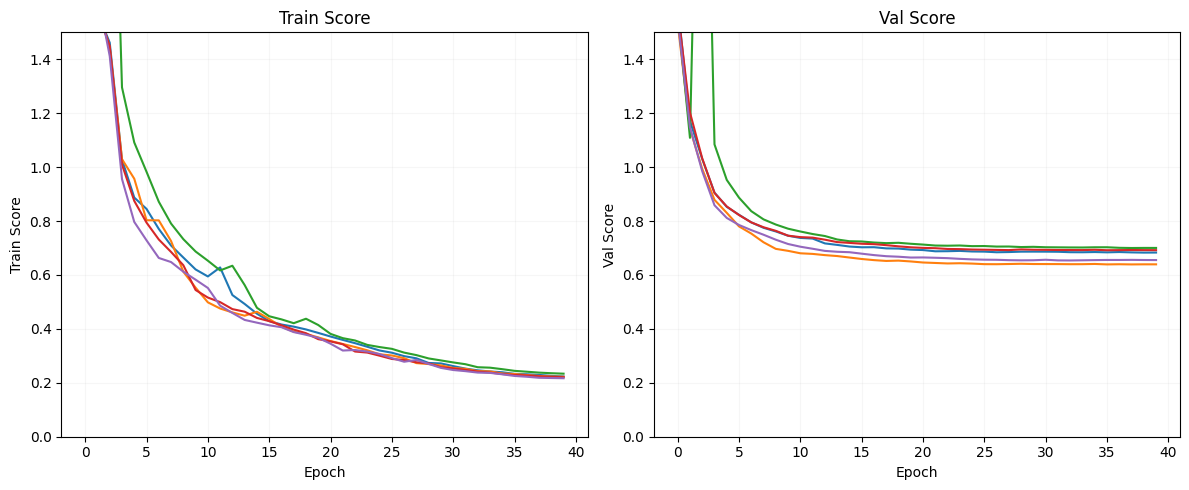

In [22]:
main()

# inference

In [23]:
class EnsembleModel:
    def __init__(self):
        self.models = []

    def __call__(self, x):
        outputs = []
        for model in self.models:
            if CFG.objective_cv == 'binary':
                outputs.append(torch.sigmoid(model(x)).to('cpu').numpy())
            elif CFG.objective_cv == 'multiclass':
                outputs.append(torch.softmax(
                    model(x), axis=1).to('cpu').numpy())
            elif CFG.objective_cv == 'regression':
                outputs.append(model(x).to('cpu').numpy())

        avg_preds = np.mean(outputs, axis=0)
        return avg_preds

    def add_model(self, model):
        self.models.append(model)


def test_fn(valid_loader, model, device):
    preds = []

    for step, (images) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)

        with torch.no_grad():
            y_preds = model(images)

        preds.append(y_preds)

    predictions = np.concatenate(preds)
    return predictions


def inference():
    test = pd.read_csv(CFG.comp_dataset_path +
                       'test_features.csv')

    test['base_path'] = CFG.comp_dataset_path + 'images/' + test['ID'] + '/'

    paths = []
    for base_path in test['base_path'].values:
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix
            paths.append(path)

    print(paths[:5])

    CFG.video_cache = make_video_cache(paths)

    print(test.head(5))

    valid_dataset = CustomDataset(
        test, CFG, transform=get_transforms(data='valid', cfg=CFG))
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    model = EnsembleModel()
    folds = [0] if CFG.use_holdout else list(range(CFG.n_fold))
    for fold in folds:
        _model = CustomModel(CFG, pretrained=False)
        _model.to(device)

        model_path = CFG.model_dir + \
            f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth'
        print('load', model_path)
        state = torch.load(model_path)['model']
        _model.load_state_dict(state)
        _model.eval()

        # _model = tta.ClassificationTTAWrapper(
        #     _model, tta.aliases.five_crop_transform(256, 256))

        model.add_model(_model)

    preds = test_fn(valid_loader, model, device)

    test[CFG.target_col] = preds
    test.to_csv(CFG.submission_dir +
                'submission_oof.csv', index=False)
    test[CFG.target_col].to_csv(
        CFG.submission_dir + f'submission_{CFG.exp_name}.csv', index=False)

In [24]:
inference()

['../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t-1.0.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t-0.5.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_220/image_t-1.0.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_220/image_t-0.5.png']
[255, 227, 199, 170, 142, 114, 85, 57, 29]


0it [00:00, ?it/s]

                                     ID      vEgo      aEgo  steeringAngleDeg  \
0  012baccc145d400c896cb82065a93d42_120  3.374273 -0.019360        -34.008415   
1  012baccc145d400c896cb82065a93d42_220  2.441048 -0.022754        307.860077   
2  012baccc145d400c896cb82065a93d42_320  3.604152 -0.286239         10.774388   
3  012baccc145d400c896cb82065a93d42_420  2.048902 -0.537628         61.045235   
4  01d738e799d260a10f6324f78023b38f_120  2.201528 -1.898600          5.740093   

   steeringTorque  brake  brakePressed  gas  gasPressed gearShifter  \
0            17.0    0.0         False  0.0       False       drive   
1           295.0    0.0          True  0.0       False       drive   
2          -110.0    0.0          True  0.0       False       drive   
3           189.0    0.0          True  0.0       False       drive   
4           -41.0    0.0          True  0.0       False       drive   

   leftBlinker  rightBlinker  \
0        False         False   
1        False        

/tmp/ipykernel_565/610043316.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)['model']


load ../proc/baseline/outputs/atmacup_18_cnn_conv_tiny/atmacup_18-models/convnextv2_tiny_fold1_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_conv_tiny/atmacup_18-models/convnextv2_tiny_fold2_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_conv_tiny/atmacup_18-models/convnextv2_tiny_fold3_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_conv_tiny/atmacup_18-models/convnextv2_tiny_fold4_last.pth


  0%|          | 0/14 [00:00<?, ?it/s]